In [1]:
from pydantic import BaseModel, field_validator, computed_field, validate_call
from pydantic.dataclasses import dataclass

In [ ]:
%load_ext autoreload
%autoreload 2
from dotenv import load_dotenv
load_dotenv()
from module_test.raw_code.optionlib_2.vol.implied_vol import (
    bsm_vol_est_brute_force,
    bsm_vol_est_minimization,
    vector_vol_estimation
)

from module_test.raw_code.optionlib_2.config.defaults import DAILY_BASIS
from module_test.raw_code.optionlib_2.assets.forward import (
    EquityForward, 
    time_distance_helper,
    vectorized_market_forward_calc
)
from datetime import datetime
from dbase.DataAPI.ThetaData import retrieve_chain_bulk
from trade.helpers.helper import change_to_last_busday, retrieve_timeseries
import os
  
from module_test.raw_code.optionlib_2.vol.implied_vol import (
    estimate_crr_implied_volatility,
    vol_est_brute_force_bjs_2002,
    vector_vol_estimation
)
from module_test.raw_code.optionlib_2.assets.forward import (
    EquityForward, 
    time_distance_helper,
    get_vectorized_dividend_rate,
    get_vectorized_dividend_scehdule,
    vectorized_discrete_pv
)

from module_test.raw_code.optionlib_2.assets.dividend import (
    vector_convert_to_time_frac
)

from module_test.raw_code.optionlib_2.greeks.numerical.bjs2002 import (
    bjs2002_numerical_greeks,
)
from module_test.raw_code.optionlib_2.greeks.numerical.black_scholes import vectorized_black_scholes_greeks

from module_test.raw_code.optionlib_2.greeks.numerical.binomial import (
    binomial_tree_greeks,
)
from datetime import datetime
from dbase.DataAPI.ThetaData import retrieve_chain_bulk
from trade.helpers.helper import change_to_last_busday, retrieve_timeseries
import os
import numpy as np
import pandas as pd
from trade.assets.rates import get_risk_free_rate_helper
from module_test.raw_code.optionlib_2.utils.batch_operation import vector_batch_processor
# os.environ['PROXY_URL'] = ''
from dbase.DataAPI.ThetaData import (
    list_contracts,
    retrieve_eod_ohlc,
    retrieve_chain_bulk
)
from trade import PRICING_CONFIG, reload_pricing_config, get_pricing_config
from dataclasses import dataclass, field
from pydantic import BaseModel, Field, ConfigDict
from pydantic.dataclasses import dataclass
from abc import ABC, abstractmethod
from typing import List, Tuple, Literal
from scipy.interpolate import interp1d
from module_test.raw_code.optionlib_2.pricing.black_scholes import black_scholes_vectorized
from module_test.raw_code.optionlib_2.pricing.binomial import crr_binomial_pricing
from module_test.raw_code.optionlib_2.greeks.numerical.binomial import binomial_tree_price_batch
from trade.helpers.Logging import setup_logger
logger =setup_logger('SSVIModel', stream_log_level='INFO')
test_start, test_valuation_date = '2025-07-16', '2025-07-16'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
reload_pricing_config()
PRICING_CONFIG= get_pricing_config()
# PRICING_CONFIG

In [4]:
ticks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
test_start, test_valuation_date = '2025-07-16', '2025-07-16'
def pick_random_option(tick, date):
    contracts = list_contracts(tick, date)
    # Pick a random contract from the list
    contract = np.random.choice(contracts.index)
    return contracts.iloc[contract]

def get_option_eod_price(date, contract_series):
    """
    Retrieves the end-of-day price for a given option contract on a specific date.
    
    Args:
        date (datetime): The date for which to retrieve the price.
        contract_series (pd.Series): The series containing option contract details.
        
    Returns:
        float: The end-of-day price of the option contract.
    """
    eod_data = retrieve_eod_ohlc(symbol=contract_series['root'],
                                  end_date=date,
                                  start_date=date,
                                  exp=str(contract_series['expiration']),
                                  right=contract_series['right'],
                                  strike=contract_series['strike'],
                                  )
    return eod_data.Midpoint[0]

def get_spot(tick, date, spot_type='close'):
    return retrieve_timeseries(tick, date, date, spot_type=spot_type)['close'][0]

def get_rates(date):
    """
    Retrieves the risk-free rate for a given date.
    
    Args:
        date (datetime): The date for which to retrieve the risk-free rate.
        
    Returns:
        float: The risk-free rate for the specified date.
    """
    date = pd.to_datetime(date).strftime('%Y-%m-%d')
    return get_risk_free_rate_helper()['annualized'][date]
r = get_rates(test_valuation_date)

[get_engine] Creating engine for DB: securities_master, PID: 89841


In [5]:
def get_chain(tick, date):
    spot = get_spot(tick, date, spot_type='chain_price')
    date= change_to_last_busday(date)
    chain=retrieve_chain_bulk(
        tick,
        0, ## This is to get all expirations
        date,
        date,
        '16:00'
    )
    chain['spot'] = spot
    chain['valuation_date'] = date
    chain['moneyness'] = chain['Strike'] / chain['spot']
    chain['log_moneyness'] = np.log(chain['moneyness'])
    chain['T']= chain['Expiration'].apply(
        lambda x: time_distance_helper(
            x,
            date,
        ))
    chain['T'] = chain['T'].astype(float)
    chain['DTE']= chain['T'] * DAILY_BASIS

    return chain


In [6]:
def format_chain(chain: pd.DataFrame) -> pd.DataFrame:
    """
    Formats the option chain DataFrame by renaming columns and converting types.
    
    Args:
        chain (pd.DataFrame): The option chain DataFrame to format.
        
    Returns:
        pd.DataFrame: The formatted option chain DataFrame.
    """
    chain.columns = chain.columns.str.lower() 
    chain['right'] = chain['right'].str.lower()
    return chain



In [7]:

def confine_chain_with_pricing_config(chain:pd.DataFrame) -> pd.DataFrame:
    """
    Confines the chain to the pricing configuration limits.
    
    Args:
        chain (pd.DataFrame): The option chain DataFrame.
            expected columns: ['dte', 'moneyness']
        
    Returns:
        pd.DataFrame: The confined option chain.
    """
    conf = get_pricing_config()
    return chain[
        (chain['dte'] >= conf['VOL_SURFACE_MIN_DTE_THRESHOLD']) &
        (chain['dte'] <= conf['VOL_SURFACE_MAX_DTE_THRESHOLD']) &
        (chain['moneyness'] >= conf['VOL_SURFACE_MIN_MONEYNESS_THRESHOLD']) &
        (chain['moneyness'] <= conf['VOL_SURFACE_MAX_MONEYNESS_THRESHOLD'])
    ]
    


In [8]:


def get_forward_price_on_chain(chain:pd.DataFrame,
                               valuation_date:str,
                               r:float,
                               div_type:str='discrete') -> pd.DataFrame:
    """
    Calculates the forward price for a given option chain.
    
    Args:
        chain (pd.DataFrame): The option chain DataFrame.
        valuation_date (str): The date of valuation.
        end_date (str): The expiration date of the option.
        r (float): The risk-free rate.
        div_type (str): Type of dividend ('discrete' or 'continuous').
        
    Returns:
        float: The calculated forward price.
    """

    ## This is per-ticker function. There must be only one ticker, one spot price
    assert len(chain['root'].unique()) == 1, "Chain must contain options from only one ticker."
    assert len(chain['spot'].unique()) == 1, "Chain must contain a single spot price."
    assert len(chain['valuation_date'].unique()) == 1, "Chain must contain a single valuation date."
    assert div_type in ['discrete', 'continuous'], "div_type must be either 'discrete' or 'continuous'."

    ## For speed, we will use unique items, and merge back later
    chain = chain.copy()
    end_dates = chain['expiration'].unique()
    valuation_dates= [valuation_date] * len(end_dates)
    S = [chain['spot'].tolist()[0]] * len(end_dates)
    tickers= [chain['root'].iloc[0]] * len(end_dates)
    r = [get_rates(valuation_date)] * len(end_dates)

    ## This function returns similar things based on div_type
    ## 1. If div_type is 'discrete', it returns the forward price, (dividend schedule & present value of dividends (It's sum of dividends))
    ## 2. If div_type is 'continuous', it returns the forward price, (dividend rate & present value of dividend rate)
    f, (actual, pv) = vectorized_market_forward_calc(
        ticks=tickers,
        S=S,
        valuation_dates=valuation_dates,
        end_dates=end_dates,
        r=r,
        div_type=div_type,
        return_div = True)
    
    ## Create a series for merging
    f = pd.Series(f, index=end_dates, name='f')
    pv = pd.Series(pv, index=end_dates, name='div_pv')

    if div_type == 'discrete':
        actual =  vector_convert_to_time_frac(
            actual,
            valuation_dates=[valuation_date] * len(actual),
            end_dates=end_dates,
        )
        


    ## Merge back to chain
    actual = pd.Series(actual, index=end_dates, name='div_schedule')
    chain = chain.merge(actual, left_on='expiration', right_index=True, how='left')
    chain = chain.merge(f, left_on='expiration', right_index=True, how='left')
    chain = chain.merge(pv, left_on='expiration', right_index=True, how='left')

    ## Calculate moneyness and log moneyness based on forward price
    chain['f_moneyness'] = chain['f'] / chain['spot']
    chain['f_log_moneyness'] = np.log(chain['f_moneyness'])

    return chain




In [9]:
def get_bs_vol_on_chain(
        chain:pd.DataFrame,
        valuation_date:str,
        rate_col_name:str=None,
        forward_col_name:str='f',
        mid_col_name:str='midpoint'
) -> pd.Series:
    """
    Estimates the Black-Scholes implied volatility for a given option chain.
    
    Args:
        chain (pd.DataFrame): The option chain DataFrame.
            Expected Columns: `f`, `strike`, `t`, `midpoint`, `right`. 
        valuation_date (str): The date of valuation.
        
    Returns:
        pd.Series: The estimated Black-Scholes implied volatility for the option chain.
    """
    if rate_col_name is None:
        _r = [get_rates(valuation_date)] * len(chain)
    else:
        _r = chain[rate_col_name]
    
    params = list(zip(
        chain[forward_col_name if forward_col_name in chain.columns else 'f'], 
        chain['strike'], 
        chain['t'],
        _r, 
        chain[mid_col_name if mid_col_name in chain.columns else 'midpoint'], 
        chain['right'].str.lower()
    ))

    return vector_batch_processor(
        vector_vol_estimation,
        bsm_vol_est_brute_force,
        params,

    )




In [153]:
def get_discrete_crr_vol_on_chain(
        chain:pd.DataFrame,
        valuation_date:str,
        rates_col_name:str=None,
        div_type:str='discrete',
        N:int=250
) -> pd.Series:
    """
    Estimates the discrete CRR implied volatility for a given option chain.
    
    Args:
        chain (pd.DataFrame): The option chain DataFrame.
            Expected Columns: `spot`, `strike`, `t`, `midpoint`, `div_schedule`, `right`.
        valuation_date (str): The date of valuation.
        
    Returns:
        pd.Series: The estimated discrete CRR implied volatility for the option chain.
    """
    ## Get risk-free rates
    if rates_col_name is None:
        _r = [get_rates(valuation_date)] * len(chain)
    else:
        _r = chain[rates_col_name].tolist()

    ## Pick div based on div_type
    if div_type not in ['discrete', 'continuous']:
        raise ValueError("div_type must be either 'discrete' or 'continuous'.")
    elif div_type == 'continuous':
        divs = chain['div_pv'].tolist()
    else:
        divs = chain['div_schedule'].tolist()

    crr_vector_params_discrete = list(zip(
        chain['spot'], chain['strike'].tolist(), ## Spot, Strike
        chain['t'], _r,  ## Time to Maturity, Risk Free Rate
        chain['midpoint'], ## Midpoint Price
        divs, ## Dividends based on div_type
        chain['right'].str.lower().tolist(), ## Option Type
        [N] * len(chain),  ## Number of Steps
        [div_type] * len(chain), ## Dividend Type
        [True] * len(chain),)) ## American==True, European==False
    

    return vector_batch_processor(
        vector_vol_estimation,
        estimate_crr_implied_volatility,
        crr_vector_params_discrete
    )


In [11]:
def intrinsic_value(
    strike: float,
    spot: float,
    right: Literal['c', 'p']
) -> float:
    """
    Calculate the intrinsic value of an option.
    
    Args:
        strike (float): The strike price of the option.
        spot (float): The current spot price of the underlying asset.
        right (Literal['c', 'p']): The type of option ('c' for call, 'p' for put).
        
    Returns:
        float: The intrinsic value of the option.
    """
    if right.lower() == 'c':
        return max(0, spot - strike)
    elif right.lower() == 'p':
        return max(0, strike - spot)
    else:
        raise ValueError(f"Invalid option type: {right}. Expected 'c' or 'p'.")
    
    

def vector_eu_boundary(
        f: np.ndarray,
        strike: np.ndarray,
        t: np.ndarray,
        r: np.ndarray,
        right: np.ndarray,

) -> np.ndarray:
    """
    Calculate the European option boundary values.
    
    Args:
        f (np.ndarray): Forward prices.
        strike (np.ndarray): Strike prices.
        t (np.ndarray): Time to maturity.
        r (np.ndarray): Risk-free rates.
        right (np.ndarray): Option types ('c' for call, 'p' for put).
        
    Returns:
        np.ndarray: The boundary values of the European options.
    """
    f = np.asarray(f)
    strike = np.asarray(strike)
    t = np.asarray(t)
    r = np.asarray(r)
    right = np.asarray(right)
    if f.shape != strike.shape or f.shape != t.shape or f.shape != r.shape or f.shape != right.shape:
        raise ValueError("All input arrays must have the same shape.")

    intrinsic_values = np.zeros_like(f)
    call = right == 'c'
    put = right == 'p'
    intrinsic_values[call] = np.maximum(0, f[call] - strike[call])
    intrinsic_values[put] = np.maximum(0, strike[put] - f[put])
    boundary = intrinsic_values * np.exp(-r * t)
    # boundary = np.zeros_like(f)
    # boundary[call] = np.maximum(0, f[call] - pv_k[call])
    # boundary[put] = np.maximum(0, pv_k[put] - f[put])
    return boundary

## Chain Prep Checklist

In [482]:

class ChainChecklist:
    """
    A class to perform various checks and transformations on option chain data.
    This class includes methods to prepare the chain, remove junk quotes, and more.
    """


    @staticmethod
    def chain_prep(chain:pd.DataFrame) -> pd.DataFrame:
        """
        Prepares the option chain DataFrame for further processing.
        Runs through various transformations.
        
        Args:
            chain (pd.DataFrame): The option chain DataFrame.
            
        Returns:
            pd.DataFrame: The prepared option chain DataFrame.
        """
        pass



    @staticmethod
    def remove_junk_quotes(chain:pd.DataFrame) -> pd.DataFrame:
        """
        Removes junk quotes from the option chain DataFrame.
        
        Args:
            chain (pd.DataFrame): The option chain DataFrame.
            
        Returns:
            pd.DataFrame: The cleaned option chain DataFrame.
        """
        
        chain = chain.copy()

        ## Format chain
        chain = format_chain(chain)
        logger.info(f"Initial chain length: {len(chain)}")
        ## Drop midpoint < intrinsic value
        chain['intrinsic_value'] = chain.apply(
            lambda x: intrinsic_value(
                x['strike'], 
                x['f'], ## Use Forward Price for intrinsic value instead of spot price
                x['right']
            ), axis=1)

        ## Drop below European lower bound
        chain['eu_lower_bound'] = vector_eu_boundary(
            chain['f'].tolist(),
            chain['strike'].tolist(),
            chain['t'].tolist(),
            [get_rates(chain['valuation_date'].iloc[0].strftime('%Y-%m-%d'))] * len(chain),
            chain['right'].str.lower().tolist()
        )
        
        ## American Options cannot be worth less than max(intrinsic value, european lower bound, 0)
        ## Less than intrinsic value: Exercise
        ## Less than european lower bound: Arbitrage Violation
        chain['lower_bound'] = chain.apply(lambda x: max( 
            x['intrinsic_value'],
            x['eu_lower_bound'],
            0), axis=1)
        
        ## Upper Bound is Spot for Call, Strike for Put
        chain['upper_bound'] = chain.apply(lambda x: x['spot'] if x['right'] == 'c' else x['strike'], axis=1)
        chain = chain[chain['midpoint'] >= chain['lower_bound']]
        chain = chain[chain['midpoint'] <= chain['upper_bound']]
        logger.info(f"Chain length after removing junk quotes: {len(chain)}")

        ## Confine chain with pricing config
        chain = confine_chain_with_pricing_config(chain)
        logger.info(f"Chain length after confining with pricing config: {len(chain)}")

        return chain
    
    @staticmethod
    def get_european_price(
        chain:pd.DataFrame,
        bs_vol: np.ndarray,
        forward_col_name: str = 'f',
        rates_col_name: str = None
        ) -> pd.Series:
        """
        Calculates the European price for the options in the chain.
        Args:
            chain (pd.DataFrame): The option chain DataFrame.
        Returns:
            pd.Series: The European price for each option in the chain.
        """
        if rates_col_name is None:
            _r = [get_rates(chain['valuation_date'].iloc[0].strftime('%Y-%m-%d'))] * len(chain)
        else:
            _r = chain[rates_col_name].tolist()

        
        chain = chain.copy()
        val_date = chain['valuation_date'].iloc[0].strftime('%Y-%m-%d')
        european_price_params = [
            chain[forward_col_name if forward_col_name in chain.columns else 'f'].tolist(),
            chain['strike'].tolist(),
            chain['t'].tolist(),
            _r,  # Risk-free rate
            bs_vol,
            chain['right'].str.lower().tolist(),
        ]


        european_midpoint = black_scholes_vectorized(*european_price_params)
        return pd.Series(european_midpoint, index=chain.index)
    
    @staticmethod
    def get_american_price(chain: pd.DataFrame,
                           sigmas: np.ndarray,
                           rates_col_name: str = None,
                           N: int = 500) -> pd.Series:
        """
        Calculates the American price for the options in the chain using a binomial tree.
        
        Args:
            chain (pd.DataFrame): The option chain DataFrame.
            N (int): The number of steps in the binomial tree.
            
        Returns:
            pd.Series: The American price for each option in the chain.
        """
        chain = chain.copy()
        val_date = chain['valuation_date'].iloc[0].strftime('%Y-%m-%d')
        if rates_col_name is None:
            _r = [get_rates(val_date)] * len(chain)
        else:
            _r = chain[rates_col_name].tolist()
        crr_params = [
            chain['strike'].tolist(),
            chain['expiration'].tolist(),
            sigmas,
            _r,  # Risk-free rate
            [N] * len(chain),  # Number of steps
            chain['spot'].tolist(),
            ['discrete'] * len(chain),  # Dividend type
            chain['div_schedule'].tolist(),  # Dividend schedules
            chain['right'].str.lower().tolist(),
            chain['valuation_date'].tolist(),  # Start dates
            chain['valuation_date'].tolist(),  # Valuation dates
            [True] * len(chain),  # American options
        ]

        def batch_hacked(*args):
            """
            A batch processor to handle the CRR binomial pricing.
            """
            return binomial_tree_price_batch(*args)[0]
        
        american_midpoint = vector_batch_processor(
            batch_hacked,
            *crr_params
        )
        chain['american_midpoint'] = american_midpoint
        return pd.Series(american_midpoint, index=chain.index)

    @staticmethod
    def run_calc_task(chain: pd.DataFrame, 
                      seed_vol: List[float],
                      N: int = 500,
                      forward_col_name: str = 'f',
                      rates_col_name: str = None
                      ) -> pd.DataFrame:
        """
        Calculates the European equivalent prices for the options in the chain.
        
        Args:
            chain (pd.DataFrame): The option chain DataFrame.
            N (int): The number of steps in the binomial tree.
            
        Returns:
            pd.DataFrame: The option chain DataFrame with European equivalent prices.
        """
        chain = chain.copy()
        mid = chain['midpoint'].to_numpy()

        ## Using bs_vol as seed because it is backed out of the midpoint
        # seed_vol = list(chain['bs_vol'].to_numpy())

        ## Using Midpoint as initial European price because seed_vol is backed out of it
        p_eu_init = ChainChecklist.get_european_price(chain=chain, 
                                                      bs_vol=seed_vol,
                                                      forward_col_name=forward_col_name,
                                                      rates_col_name=rates_col_name)

        ## Calculate American prices using CRR Binomial model and Seed Vol
        p_am = ChainChecklist.get_american_price(chain=chain, 
                                                 sigmas=seed_vol, 
                                                 N=N,
                                                 rates_col_name=rates_col_name)

        ## Calculate Early Exercise Premium (EEP) and European Equivalent Price
        EEP = np.array(p_am - p_eu_init)
        euro_eq_mid = list(mid - EEP)

        ## Calculate European equivalent volatilities
        sigmas = ChainChecklist.get_bs_vol_on_chain(
            chain,
            chain['valuation_date'].iloc[0].strftime('%Y-%m-%d'),
            euro_eq_mid,
            rate_col_name=rates_col_name,
            forward_col_name=forward_col_name
        )

        chain['european_midpoint'] = p_eu_init
        chain['european_vols_equiv'] = sigmas
        chain['american_midpoint'] = p_am
        chain['early_exercise_premium'] = EEP
        chain['european_equivalent_mid'] = euro_eq_mid
        return chain
    
    @staticmethod
    def calculate_european_equivalent_vols(chain: pd.DataFrame, 
                                           N: int = 500, 
                                           iteration: int = 4,
                                           seed_vol_col:str = None,
                                           forward_col_name: str = 'f',
                                           rates_col_name: str = None, 
                                           valuation_date: str|datetime = None
                                           ) -> pd.DataFrame:
        """
        Iterates the run_calc_task to refine the European equivalent prices and volatilities.
        """

        def _name_not_include_error(col_name: str, columns: pd.Index) -> bool:
            if col_name not in columns:
                raise ValueError(f"{col_name} not found in chain columns: {columns.tolist()}")
            return False

        ## Valuation date validation
        if valuation_date is None:
            try:
                valuation_date = pd.to_datetime(chain['valuation_date'].iloc[0])
            except Exception as e:
                raise ValueError("valuation_date must be provided if chain does not contain 'valuation_date' column.") from e
        else:
            valuation_date = pd.to_datetime(valuation_date)

        if rates_col_name is None:
            rates_col_name = 'risk_free_rate' 
            
        ## Rates column validation
        if rates_col_name not in chain.columns:
            if rates_col_name != 'risk_free_rate':
                print(f"Warning: {rates_col_name} not found in chain columns. Defaulting to 'risk_free_rate'.")
            rates_col_name = 'risk_free_rate'
            chain[rates_col_name] = get_rates(valuation_date.strftime('%Y-%m-%d'))


        ## Seed Vol column validation
        if seed_vol_col is None:
            seed_vol_col = 'bs_vol'
            chain[seed_vol_col] = get_bs_vol_on_chain(
                chain=chain,
                valuation_date=chain['valuation_date'].iloc[0].strftime('%Y-%m-%d'),
                mid_col_name='midpoint',
                rate_col_name=rates_col_name,
                forward_col_name=forward_col_name
            )
        
        ## Seed vol column validation P2
        elif seed_vol_col not in chain.columns:
            _name_not_include_error(seed_vol_col, chain.columns)
        
        ## Forward column validation
        _name_not_include_error(forward_col_name, chain.columns) 


        ## Begin process
        seed_vol = list(chain[seed_vol_col].to_numpy())
        for i in range(iteration):
            print(f"Iteration {i+1} of {iteration}")
            chain = ChainChecklist.run_calc_task(chain,
                                                 seed_vol, 
                                                 N, 
                                                 forward_col_name=forward_col_name,
                                                 rates_col_name=rates_col_name)

            if i == iteration - 1:
                break ## Last iteration, no need to reset variables
            
            ## Reset Variables for rerun
            seed_vol = list(chain['european_vols_equiv'].to_numpy())
        return chain

    
    @staticmethod
    def get_bs_vol_on_chain(
        chain: pd.DataFrame,
        valuation_date: str,
        midpoints: pd.Series,
        rate_col_name: str = None,
        forward_col_name: str = 'f'
    ) -> pd.Series:
        """
        Estimates the Black-Scholes implied volatility for a given option chain.
        
        Args:
            chain (pd.DataFrame): The option chain DataFrame.
                Expected Columns: `f`, `strike`, `t`, `midpoint`, `right`. 
            valuation_date (str): The date of valuation.
            
        Returns:
            pd.Series: The estimated Black-Scholes implied volatility for the option chain.
        """
        if rate_col_name is None:
            _r = [get_rates(valuation_date)] * len(chain)   

        else:
            _r = chain[rate_col_name]
        params = list(zip(
            chain[forward_col_name if forward_col_name in chain.columns else 'f'], 
            chain['strike'], 
            chain['t'],
            _r,
            midpoints, 
            chain['right'].str.lower()
        ))
        return vector_batch_processor(
            vector_vol_estimation,
            bsm_vol_est_brute_force,
            params,
        )

# for tick, chain in chains.items():
#     print(f"Size before removing junk quotes in {tick}: {chain.shape[0]}")
#     chains[tick] = ChainChecklist.remove_junk_quotes(chain)
#     print(f"Size after removing junk quotes: {chains[tick].shape[0]}")


In [ ]:

def get_expected_column(col, 
                        chain:pd.DataFrame,
                        valuation_date:str=None,
                        div_type:str='discrete'):
    """
    Retrieves the expected column value for a given option chain.
    Args:

        col (str): The column to retrieve ('f', 't', 'div_schedule', 'spot').
        chain (pd.DataFrame): The option chain DataFrame.
        valuation_date (str): The date of valuation.
        div_type (str): Type of dividend ('discrete' or 'continuous').
    Returns:
        float or pd.Series: The expected value for the specified column.
    """
    if col == 'f':
        return get_forward_price_on_chain(
            chain,
            valuation_date,
            get_rates(valuation_date),
            div_type=div_type
        )
    elif col == 't':
        return chain['expiration'].apply(
            lambda x: time_distance_helper(
                x,
                valuation_date,
            )
        ).astype(float)
    elif col == 'div_schedule':
        return get_dividend_schedule_on_chain(
            chain,
            valuation_date
        )
    elif col == 'spot':
        return get_spot(chain['root'].iloc[0], valuation_date)
    


def validate_chain_columns(
                            chain: pd.DataFrame,
                            valuation_date: str,
                            required_columns: list = None,
                            expected_columns: list = None,
                            div_type: str = 'discrete') -> pd.DataFrame    :
    """
    Validates that the required columns are present in the chain DataFrame.
    Raises ValueError if any required column is missing.
    """
    # Ensure chain is formatted
    chain=format_chain(chain)
    chain=confine_chain_with_pricing_config(chain)
    chain['valuation_date'] = valuation_date 
    
    # Define required columns based on the model
    if required_columns is None:
        required_columns = ['expiration', 'strike', 'right', 'midpoint', 'f', 'spot']

    ## Check for required columns
    for col in required_columns:
        if col not in chain.columns.str.lower():
            raise ValueError(f"Missing required column: {col} in chain DataFrame")
    
    # Check for optional columns and fill them if missing
    if expected_columns is None:
        expected_columns = ['t']
    for col in expected_columns:
        if col not in chain.columns.str.lower():
            # If the column is missing, we will fill it with default values
            if col=='spot': assert 'root' in chain.columns.str.lower(), \
                "Missing 'root' column in chain DataFrame for spot price retrieval"
            logger.warning(f"Column {col} is missing in the chain DataFrame. Filling with default values.")
            chain[col] = get_expected_column(col,
                                             chain=chain,
                                             valuation_date=valuation_date,
                                             div_type=div_type)

    
    chain.columns = chain.columns.str.lower()  # Normalize column names to lowercase
    chain['moneyness']= chain['strike'] / chain['spot']
    chain['log_moneyness'] = np.log(chain['moneyness'])
    chain['fwd_moneyness']= chain['f'] / chain['strike']
    chain['dte'] = chain['t'] * DAILY_BASIS  # Convert T to DTE
    call_chain = chain[chain['right'].str.lower() == 'c'].copy()
    put_chain = chain[chain['right'].str.lower() == 'p'].copy()
    return call_chain, put_chain, chain
        


def calculate_vol(
        chain: pd.DataFrame,
        valuation_date: str,
        N: int = 250,
        model: str = 'binomial',
):
    
    if 'vol' not in chain.columns.str.lower():
        logger.info("Calculating implied volatility for the option chain. Model is set to '%s'.", model)
        if model == 'bs':
            # Use Black-Scholes model for volatility estimation
            chain['vol'] = get_bs_vol_on_chain(chain, valuation_date)

        elif model == 'binomial':
            # Use Binomial model for volatility estimation
            chain['vol'] = get_discrete_crr_vol_on_chain(chain, valuation_date, N=N)
    return chain



## SSVI 

In [330]:
import numpy as np
from typing import List, Tuple, Callable
import math
from trade.helpers.pools import runProcesses

# -------------------------------------------------
# 1. Black-Scholes Call price       (no SciPy need)
# -------------------------------------------------
def normal_cdf(x):                       # Φ(x)
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2)))

def bs_call_price(spot, strike, maturity, rate, vol):
    """Black-Scholes European call."""
    if vol <= 0 or maturity <= 0:
        return max(0.0, spot - strike)
    d1 = (math.log(spot / strike) + (rate + 0.5 * vol**2) * maturity) / (vol * math.sqrt(maturity))
    d2 = d1 - vol * math.sqrt(maturity)
    return (spot * normal_cdf(d1) -
            strike * math.exp(-rate * maturity) * normal_cdf(d2))

# -------------------------------------------------
# 2. SSVI helpers
# -------------------------------------------------
def atm_total_variance(t, var0, var_inf, kappa):
    """
    θ(t)  = ((var0 - var_inf)*(1 - e^{-κ t})/(κ t) + var_inf) * t
    """
    return ((var0 - var_inf) * (1 - np.exp(-kappa * t))
            / (kappa * t) + var_inf) * t

def skew_phi(theta_t, eta, lam):
    return eta * theta_t ** lam

def ssvi_total_variance(log_moneyness, theta_t, eta, lam, rho):
    phi_val = skew_phi(theta_t, eta, lam)
    term1   = rho * phi_val * log_moneyness
    term2   = np.sqrt((phi_val * log_moneyness + rho)**2 + 1 - rho**2)
    return 0.5 * theta_t * (1 + term1 + term2)

def ssvi_implied_vol(fwd, strike, maturity,
                     var0, var_inf, kappa,
                     eta, lam, rho):
    """Return σ implied by SSVI."""
    k = np.log(strike / fwd)                    # log-moneyness
    theta_t = atm_total_variance(maturity, var0, var_inf, kappa)
    total_var = ssvi_total_variance(k, theta_t, eta, lam, rho)
    return np.sqrt(total_var / maturity)

def make_candidate(bounds: List[Tuple[float, float]], iterations) -> np.ndarray:
    """
    Generate a random candidate solution within the given bounds.
    bounds: list of (low, high) for each dimension
    """
    rng = np.random.default_rng(42)
    low  = np.array([b[0] for b in bounds])
    high = np.array([b[1] for b in bounds])

    # (iterations, d) matrix of uniform random samples
    candidates = low + (high - low) * rng.random((iterations, len(bounds)))
    return candidates


def random_search_vec(objective_multi: Callable[[np.ndarray], np.ndarray],
                      bounds: List[Tuple[float, float]],
                      iterations: int = 40_000) -> Tuple[np.ndarray, float]:
    """
    Vectorised random search.
    objective_multi: accepts an (N, d) array -> returns (N,) array of losses
    bounds         : list of (low, high) for each dimension
    iterations     : how many random draws
    """

    # vectorised loss evaluation -> (iterations,)
    candidates = make_candidate(bounds, iterations)
    _losses = objective_multi(candidates)
    best_idx = np.argmin(_losses)
    return candidates[best_idx], _losses[best_idx]


def atm_loss_multi(X, t, iv_atm):
    """
    X : (N, 3)  – rows = [var0, var_inf, kappa]
    t, iv_atm   – market ATM maturities and vols (1-D)
    returns     – loss for each row  (shape (N,))
    """
    var0, var_inf, kappa = X[:, 0], X[:, 1], X[:, 2]
    theta_t  = atm_total_variance(t[:, None], var0, var_inf, kappa)  # broadcast
    model_iv = np.sqrt(theta_t / t[:, None])
    mse      = ((model_iv - iv_atm[:, None])**2).mean(axis=0)        # → (N,)

    # guard against NaN / huge vols
    invalid   = (np.isinf(mse)) | (np.isnan(mse))
    mse = np.where(invalid, 1e4, mse)  # penalise
    return mse

def surface_loss_multi(params_mat, K_grid, T_grid, fwd,
                       var0_hat, var_inf_hat, kappa_hat,
                       market_iv, weights=None):
    """
    params_mat : (N,3) rows [eta, lambda, rho]
    returns    : (N,)   weighted MSE per candidate
    """
    eta, lam, rho = params_mat.T
    M = K_grid.shape[0]

    # normalize weights -> (M,)
    if weights is None:
        weights = np.ones(M, dtype=float)
    else:
        weights = np.asarray(weights, dtype=float)
        if weights.ndim != 1 or weights.shape[0] != M:
            raise ValueError(f"weights must be shape ({M},), got {weights.shape}")

    bad = (eta <= 0) | (lam <= -0.9) | (lam >= 1.0) | (np.abs(rho) >= 0.999)
    safe_eta = np.where(bad, 1.0, eta)
    safe_lam = np.where(bad, 0.0, lam)
    safe_rho = np.where(bad, 0.0, rho)

    k = np.log(K_grid / fwd)[:, None]     # (M,1)
    T = T_grid[:, None]                   # (M,1)
    theta = atm_total_variance(T, var0_hat, var_inf_hat, kappa_hat)

    total_var = ssvi_total_variance(
        k, theta, safe_eta[None, :], safe_lam[None, :], safe_rho[None, :]
    )                                      # (M,N)

    iv_model = np.sqrt(total_var / T)      # (M,N)
    invalid = (~np.isfinite(iv_model)) | (iv_model > 5)
    iv_model = np.where(invalid, 1e4, iv_model)

    sqerr = (iv_model - market_iv[:, None]) ** 2   # (M,N)

    # ✅ weighted mean over M → shape (N,)
    wmse = np.average(sqerr, axis=0, weights=weights)

    # slam bad candidates
    wmse = np.where(bad, 1e9, wmse)
    return wmse






In [324]:
def _loss_chunk_with_idx(idx,
                         params_chunk,
                         K_grid, T_grid, fwd,
                         var0_hat, var_inf_hat, kappa_hat,
                         market_iv):
    # Call your original function on a chunk
    mse = surface_loss_multi(params_chunk,
                             K_grid, T_grid, fwd,
                             var0_hat, var_inf_hat, kappa_hat,
                             market_iv)
    return idx, mse  # keep index so we can reassemble in order


def surface_loss_multi_parallel(params_mat,
                                K_grid, T_grid, fwd,
                                var0_hat, var_inf_hat, kappa_hat,
                                market_iv,
                                *,
                                chunk_size=1024,
                                run_type='imap'):
    """
    Parallel wrapper around surface_loss_multi using runProcesses.
    params_mat: (N,3) -> returns (N,)
    No globals; constants are passed to each worker.
    """
    N = int(params_mat.shape[0])
    if N == 0:
        return np.empty((0,), dtype=float)

    # 1) Make chunks
    chunks = [params_mat[i:min(i+chunk_size, N)] 
              for i in range(0, N, chunk_size)]
    idxs   = list(range(len(chunks)))
    n      = len(chunks)

    # 2) Build OrderedInputs for your runProcesses(func, [args1, args2, ...])
    OrderedInputs = [
        idxs,
        chunks,
        [K_grid]      * n,
        [T_grid]      * n,
        [fwd]         * n,
        [var0_hat]    * n,
        [var_inf_hat] * n,
        [kappa_hat]   * n,
        [market_iv]   * n,
    ]

    # 3) Fan out
    results = runProcesses(_loss_chunk_with_idx, OrderedInputs, run_type=run_type)

    # 4) Materialize depending on run_type
    if run_type == 'amap':              # async ordered
        results = results.get()
    elif run_type in ('imap', 'uimap'): # iterator / unordered
        results = list(results)

    # 5) Reassemble in original order of rows
    results.sort(key=lambda x: x[0])                 # by chunk index
    mse_chunks = [m for _, m in results]
    return np.concatenate(mse_chunks, axis=0)


In [228]:
atm_iv ={}
atm_T={}


def get_atm_vol(chain: pd.DataFrame,
                log_moneyness_col_name: str='log_moneyness',
                vol_col_name: str='crr_vol_discrete') -> pd.Series:
    """
    Finds the ATM volatility for a given expiration in the chain.
    Args:
        x (pd.DataFrame): The option chain DataFrame for a specific expiration.
    Returns:
        float: The ATM volatility for the given expiration.
    """
    def finder(x):
        min_l_m= abs(x[log_moneyness_col_name]).min()
        return x[x[log_moneyness_col_name].abs() == min_l_m][vol_col_name].values[0]
    return chain.groupby('expiration').apply(finder).values

def get_atm_T(chain: pd.DataFrame,
               log_moneyness_col_name: str='log_moneyness',
               t_col_name: str='t') -> pd.Series:
    """
    Finds the ATM time to expiration for a given expiration in the chain.
    
    Args:
        chain (pd.DataFrame): The option chain DataFrame for a specific expiration.
        
    Returns:
        pd.Series: The ATM time to expiration for the given expiration.
    """
    def finder(x):
        min_l_m= abs(x[log_moneyness_col_name]).min()
        return x[x[log_moneyness_col_name].abs() == min_l_m][t_col_name].values[0]
    return chain.groupby('expiration').apply(finder).values


In [17]:
params={}
def get_best_params(T_atm: List[float],
                    iv_atm: List[float]) -> Tuple[np.ndarray, float]:
    """
    Find the best parameters for the ATM term structure.
    Returns:
        var0_hat, var_inf_hat, kappa_hat
    """
    bounds = [(1e-4, 0.2), # var0: Min ATM Variance across DTE
              (1e-4, 0.2), # var_inf_hat: Max ATM Variance across DTE
              (0.05, 3.0)] # kappa: Speed from var0 to var_inf_hat
    best_params, best_loss = random_search_vec(
        lambda X: atm_loss_multi(X, T_atm, iv_atm),
        bounds,
        iterations=3000
    )
    return best_params, best_loss


# best_params, best_loss = get_best_params()
# var0_hat, var_inf_hat, kappa_hat = best_params
# print("best", best_params, "loss", best_loss)



In [18]:
# for tick in chains:
#     print(f"Calculating best params for {tick} on {test_valuation_date}")
#     (var0_hat, var_inf_hat, kappa_hat), atm_loss = get_best_params(
#         atm_T[tick],
#         atm_iv[tick]
#     )
#     params[tick] = {
#         'var0_hat': var0_hat,
#         'var_inf_hat': var_inf_hat,
#         'kappa_hat': kappa_hat,
#         'atm_loss': atm_loss
#     }

#     print(f"Done for {tick} on {test_valuation_date}")
# params

In [19]:
k_grid = {}
t_grid = {}
market_iv_grid= {}
fwd_grid= {}

def get_K_grid(chain:pd.DataFrame) -> np.ndarray:
    """
    Retrieves the strike prices from the option chain.
    
    Args:
        chain (pd.DataFrame): The option chain DataFrame.
        
    Returns:
        np.ndarray: The strike prices for the option chain.
    """
    return chain['strike'].values

def get_T_grid(chain:pd.DataFrame) -> np.ndarray:
    """
    Retrieves the maturities from the option chain.
    
    Args:
        chain (pd.DataFrame): The option chain DataFrame.
        
    Returns:
        np.ndarray: The maturities for the option chain.
    """
    return chain['t'].values

def get_market_iv_grid(chain:pd.DataFrame) -> np.ndarray:
    """
    Retrieves the market implied volatilities from the option chain.
    
    Args:
        chain (pd.DataFrame): The option chain DataFrame.
        
    Returns:
        np.ndarray: The market implied volatilities for the option chain.
    """
    return chain['vol'].values

def get_fwd_grid(chain:pd.DataFrame) -> float:
    """
    Retrieves the forward price from the option chain.
    
    Args:
        chain (pd.DataFrame): The option chain DataFrame.
        
    Returns:
        float: The forward price for the option chain.
    """
    return chain['f'].iloc[0]  # Assuming F is constant across the chains


# for tick in refined_chains:
#     print(f"Calculating K, T, market IV and F for {tick} on {test_valuation_date}")
#     k_grid[tick] = get_K_grid(refined_chains[tick])
#     t_grid[tick] = get_T_grid(refined_chains[tick])
#     market_iv_grid[tick] = get_market_iv_grid(refined_chains[tick])
#     fwd_grid[tick] = get_fwd_grid(refined_chains[tick])
#     print(f"Done for {tick} on {test_valuation_date}")

In [ ]:

def get_surface_params(
        k_grid: np.ndarray,
        t_grid: np.ndarray,
        fwd_grid: float,
        var0_hat: float,
        var_inf_hat: float,
        kappa_hat: float,
        market_iv_grid: np.ndarray,
        iterations: int = 50_000,
        chunk_size: int = None
) -> Tuple[float, float, float, float]:
        """
        Estimate the SSVI surface parameters (eta, lambda, rho) using random search.
        Args:
        k_grid (np.ndarray): The strike prices.
        t_grid (np.ndarray): The maturities.
        fwd_grid (float): The forward price.
        var0_hat (float): Estimated initial variance.
        var_inf_hat (float): Estimated long-term variance.
        kappa_hat (float): Estimated speed of mean reversion.
        market_iv_grid (np.ndarray): Market implied volatilities.
        iterations (int): Number of random search iterations.
        chunk_size (int): Size of chunks for parallel processing.
        Returns:
        Tuple[float, float, float, float]: Estimated parameters (eta, lambda, rho) and best loss.
        """
        if chunk_size is None:
            chunk_size = int(iterations / 8)

        # 1️⃣ tighter parameter bounds
        surf_bounds = [(0.05, 1.5),      # eta
                        (-0.8, 0.8),      # lambda
                        (-0.95, 0.95)]    # rho


        surface_lamba = lambda X: surface_loss_multi_parallel(X, K_grid=k_grid, 
                                                        T_grid=t_grid,
                                                        fwd=fwd_grid,
                                                        var0_hat=var0_hat,
                                                        var_inf_hat=var_inf_hat,
                                                        kappa_hat=kappa_hat,
                                                        market_iv=market_iv_grid,
                                                        chunk_size=chunk_size)
        (eta_hat, lambda_hat, rho_hat), best_loss = random_search_vec(surface_lamba,
                                                                      surf_bounds, 
                                                                      iterations)

        return eta_hat, lambda_hat, rho_hat, best_loss



In [21]:
# for tick in refined_chains:
#     print(f"Calculating surface params for {tick} on {test_valuation_date}")
#     eta_hat, lambda_hat, rho_hat, best_loss = get_surface_params(
#         k_grid[tick],
#         t_grid[tick],
#         fwd_grid[tick],
#         params[tick]['var0_hat'],
#         params[tick]['var_inf_hat'],
#         params[tick]['kappa_hat'],
#         market_iv_grid[tick]
#     )
#     params[tick].update({
#         'eta_hat': eta_hat,
#         'lambda_hat': lambda_hat,
#         'rho_hat': rho_hat,
#         'surface_loss': best_loss
#     })
#     print(f"Done for {tick} on {test_valuation_date}")

In [22]:
def calculate_normalized_rmse_loss(
        market_iv: np.ndarray,
        model_iv: np.ndarray,
        moneyness: np.ndarray,
) -> Tuple[float, float, float]:
    
    """
    Calculate the normalized loss between market and model implied volatilities.
    
    Args:
        market_iv (np.ndarray): Market implied volatilities.
        model_iv (np.ndarray): Model implied volatilities.
        moneyness (np.ndarray): Moneyness values.
        
    Returns:
        Tuple[float, float, float]: Normalized median loss, right wing loss, left wing loss.
    """
    
    ## Normalized Median
    median_iv = np.median(market_iv)
    normalized_median_loss = np.sqrt(np.mean((market_iv - model_iv)**2)) / median_iv

    ## Right Wing Loss (> 1.0)
    right_wing_mask = moneyness > 1.0
    median_right_wing_iv = np.median(market_iv[right_wing_mask])
    right_wing_loss = np.sqrt(np.mean(
        (market_iv[right_wing_mask] - model_iv[right_wing_mask]) **2)) / median_right_wing_iv

    ## Left Wing Loss (< 1.0)
    left_wing_mask = moneyness < 1.0
    median_left_wing_iv = np.median(market_iv[left_wing_mask])
    left_wing_loss = np.sqrt(np.mean(
        (market_iv[left_wing_mask] - model_iv[left_wing_mask])**2)) / median_left_wing_iv

    return normalized_median_loss, right_wing_loss, left_wing_loss



In [23]:
def calculate_normalized_mae_loss(
        market_iv: np.ndarray,
        model_iv: np.ndarray,
        moneyness: np.ndarray
) -> Tuple[float, float, float]:
    """
    Calculate the normalized mean absolute error (MAE) loss between market and model implied volatilities.
    
    Args:
        market_iv (np.ndarray): Market implied volatilities.
        model_iv (np.ndarray): Model implied volatilities.
        moneyness (np.ndarray): Moneyness values.
        
    Returns:
        Tuple[float, float, float]: Normalized median MAE loss, right wing MAE loss, left wing MAE loss.
    """
    
    ## Normalized Median
    median_iv = np.median(market_iv)
    normalized_median_mae_loss = np.mean(np.abs(market_iv - model_iv)) / median_iv

    ## Right Wing Loss (> 1.0)
    right_wing_mask = moneyness > 1.0
    median_right_wing_iv = np.median(market_iv[right_wing_mask])
    right_wing_mae_loss = np.mean(
        np.abs(market_iv[right_wing_mask] - model_iv[right_wing_mask])) / median_right_wing_iv

    ## Left Wing Loss (< 1.0)
    left_wing_mask = moneyness < 1.0
    median_left_wing_iv = np.median(market_iv[left_wing_mask])
    left_wing_mae_loss = np.mean(
        np.abs(market_iv[left_wing_mask] - model_iv[left_wing_mask])) / median_left_wing_iv

    return normalized_median_mae_loss, right_wing_mae_loss, left_wing_mae_loss

In [24]:
## DATE UTILS

from dbase.DataAPI.ThetaData import (
    extract_numeric_value)
from datetime import date, datetime


def identify_length_for_model(string, integer) -> int:
    """
    
    Identify the length of the timeframe in minutes based on the string and integer provided.
    Parameters
    
    ----------
    string : str
        The string representing the timeframe (e.g., 'm', 'd', 'w', 'y').
    integer : int
    The integer representing the number of units for the timeframe.
    Returns
    -------
    int
        The length of the timeframe in minutes.
    
    """

    TIMEFRAMES_VALUES = {'d': 1, 'w': 7, 'm': 30, 'y': DAILY_BASIS}
    assert string in TIMEFRAMES_VALUES.keys(
    ), f'Available timeframes are {TIMEFRAMES_VALUES.keys()}, recieved "{string}"'
    return integer * TIMEFRAMES_VALUES[string]

def convert_date_to_time_to_maturity(dt: str,
                                     valuation_date: str = None) -> float:
    """
    Converts a date to time to maturity in years.
    
    Args:
        dt (datetime): The date to convert.
            example: '3m', '2025-08-08', 1
        
    Returns:
        float: Time to maturity in years.
    """

    ## If dt is a string, check if it is a date or a duration
    if isinstance(dt, (str, pd.Timestamp, datetime, date)):
        try:
            # Try to parse as a date first
            dt = pd.to_datetime(dt)
            assert valuation_date is not None, "valuation_date must be provided if dt is a date string"
            valuation_date = pd.to_datetime(valuation_date)
            dt = (dt - valuation_date).days
        except ValueError:
            # If it fails, assume it's a duration
            dt = identify_length_for_model(*extract_numeric_value(dt))
            if dt is None:
                raise ValueError(f"Invalid date or duration format: {dt}")
    elif isinstance(dt, (float,int)):
        # If dt is a number, assume it's a duration in days
        dt = float(dt)
    elif isinstance(dt, pd.Timedelta):
        # If dt is a timedelta, convert it to days
        dt = dt.days

    else:
        raise ValueError(f"Unsupported type for dt: {type(dt)}. Expected str, int, float, datetime, or pd.Timedelta.")

    assert_dt_within_range(dt)
    return dt/DAILY_BASIS

def assert_dt_within_range(dt: float):
    """
    Asserts that the time to maturity is within the range defined by PRICING_CONFIG.
    
    Args:
        dt (float): The time to maturity in years.
        
    Raises:
        ValueError: If dt is not within the configured range.
    """
    if not (PRICING_CONFIG['VOL_SURFACE_MIN_DTE_THRESHOLD'] <= dt <= PRICING_CONFIG['VOL_SURFACE_MAX_DTE_THRESHOLD']):
        raise ValueError(f"Time to maturity {dt} is out of bounds. "
                         f"Must be between {PRICING_CONFIG['VOL_SURFACE_MIN_DTE_THRESHOLD']} and {PRICING_CONFIG['VOL_SURFACE_MAX_DTE_THRESHOLD']}.")

convert_date_to_time_to_maturity('3m')

0.2464065708418891

In [428]:
## Strike Convert Utils

def assert_k_bounds_model_range(k: list | np.ndarray,
                                f: float | np.ndarray) -> None:
    """
    Asserts that the strikes are within the bounds defined by PRICING_CONFIG.
    Args:
        k (list or np.ndarray): List of strikes.
    Raises:
        ValueError: If any strike is not within the configured bounds.
    """
    conf = get_pricing_config()
    k = np.array(k, dtype=float)
    if not np.all((k <= f * (conf['VOL_SURFACE_MAX_MONEYNESS_THRESHOLD'])) &
                    (k >= f * (conf['VOL_SURFACE_MIN_MONEYNESS_THRESHOLD']))):
            raise ValueError(f"Strikes {k} are out of bounds. "
                             f"Must be between {f * (conf['VOL_SURFACE_MIN_MONEYNESS_THRESHOLD'])} and {f * (conf['VOL_SURFACE_MAX_MONEYNESS_THRESHOLD'])}.")

def handle_strikes(
    k: list| np.ndarray,
    f: list| float, 
    strike_type: Literal['p', 'k', 'pf', 'f'],
    spot: float = None
) -> np.ndarray:
    """
    Convert strikes based on the specified strike type.
    Since SSVI model takes strikes values as absolute values, this function converts the strikes
    
    Args:
        k (list or np.ndarray): List of strikes.
        f (list or float): Forward price.
        strike_type (str): Type of strike ('p', 'k', 'pf', 'f').
    
    Types available:
        - 'p': Percent of spot eg: 1.0 == ATM
        - 'k': Strike to fwd_grid: if spot = 100, k=100=ATM
        - 'pf': Percent of fwd_grid/forward price eg: 1.0 == ATMF
        - 'f': Log moneyness to fwd_grid: 0.0 == ATMF
        
    Returns:
        np.ndarray: Converted strikes.
    """
    k = np.array(k, dtype=float)
    if strike_type == 'p': ## Percent of spot to fwd_grid
        if spot is None:
            raise ValueError("Spot price must be provided for 'p' strike type.")
        
        strikes= k * spot
    elif strike_type == 'k': ## Strike to fwd_grid
        strikes= k
    elif strike_type == 'pf': ## Percent of fwd_grid/forward price
        strikes= k * f
    elif strike_type == 'f': ## Log moneyness to fwd_grid
        ## Convert log moneyness to strikes
        strikes= np.exp(k) * f

    else:
        raise ValueError(f"Invalid strike type: {strike_type}")
    assert_k_bounds_model_range(strikes, f)
    return strikes



## Model Classes

- `SSVIModelParams`: Parameters dataclass
- `BaseSSVIModel`: ABC class for SSVI Model
- `SSVIModel`: The model that expects simple inputs, and calibrates accordingly
- `MarketSSVIModel (EODMarketSSVIModel, IntraMarketSSVIModel)`: Market aware class respnsible for initiating necessary items (Differentiating btwn EOD & Intra might be unnecessary)
- `ChainInputModel`: Responsible for creating the chain and populating with respective columns
- `MarketChainInputModel`: Market aware that feeds to ChainInputModel
- `ChainOutput`: dataclass holding the chain and respective information
- `SSVI_GlobalConfig`: Class holding information useful for ssvi. Eg when predicting vol, to predict on Put chain, Call chain or OTM chain

In [446]:
from dataclasses import dataclass, field
from pydantic import BaseModel, Field, ConfigDict, PrivateAttr, model_validator
from pydantic.dataclasses import dataclass
from abc import ABC, abstractmethod
from typing import List, Optional, Literal
from scipy.interpolate import interp1d
from trade.helpers.Logging import setup_logger
import pandas as pd
from enum import Enum, auto
from concurrent.futures import ThreadPoolExecutor

### Global Config

In [ ]:
from dataclasses import dataclass as stdlib_dataclass, field as stdlib_field
from typing import ClassVar, Final
GLOBAL_CONFIG = None

class VolSide(str, Enum):
    CALL = 'call'
    PUT = 'put'
    OTM = 'otm'

class VolType(str, Enum):
    BS = 'bs'
    BINOMIAL = 'binomial'

class DivType(str, Enum):
    DISCRETE = 'discrete'
    CONTINUOUS = 'continuous'


@stdlib_dataclass
class SSVIGlobalConfig:
    """
    Singleton class for global configuration of the SSVI model.
    There will only be one instance of this class. Whether you create a new instance or use the instance() method,
    you will always get the same object.

    Intention is to provide a centralized configuration for the SSVI model that can be easily accessed and modified.
    """
    __SINGLETON__: ClassVar[bool] = True
    _CREATED: ClassVar[Optional["SSVIGlobalConfig"]] = None
    _initialized: ClassVar[bool] = False
    """
    Global configuration for SSVI model.
    Attributes:
        vol_side (VolSide): Which side of the volatility surface to model ('call', 'put', 'otm').
        div_type (DivType): Type of dividends to consider ('discrete', 'continuous').
        vol_type (VolType): Type of volatility to use for calibration ('bs', 'binomial').
        N (int): Number of steps for binomial model.
        iteration (int): Number of iterations for refining European equivalent volatilities.
    """
    vol_side: VolSide = stdlib_field(default=VolSide.OTM)
    div_type: DivType = stdlib_field(default=DivType.DISCRETE)
    vol_type: VolType = stdlib_field(default=VolType.BINOMIAL)
    N: int = stdlib_field(default=250)
    iteration: int = stdlib_field(default=2)
    chunk_size: int = stdlib_field(default=5000)
    model_iterations: int = stdlib_field(default=50_000)

    def __new__(cls, *args, **kwargs):
        if cls.__SINGLETON__ and cls._CREATED is not None:
            return cls._CREATED
        instance = super().__new__(cls)
        cls._CREATED = instance
        return instance

    def __init__(self):
        if self._initialized:
            return
        self._initialized = True

    @classmethod
    def instance(cls):
        if cls._CREATED is None:
            cls._CREATED = cls()
        return cls._CREATED

    @classmethod
    def reset(cls):
        cls._CREATED = None

    def __setattr__(self, name, value):
        ## Ensure enum values are valid
        enum_names = {
            'vol_side': VolSide,
            'div_type': DivType,
            'vol_type': VolType,    
        }
        if name in enum_names:
            if isinstance(value, str):
                try:
                    value = enum_names[name](value)
                except ValueError:
                    raise ValueError(f"Invalid value '{value}' for {name}. Allowed values are: {[e.value for e in enum_names[name]]}")
            elif not isinstance(value, enum_names[name]):
                raise ValueError(f"{name} must be an instance of {enum_names[name]}")
        super().__setattr__(name, value)

def set_global_config(config: SSVIGlobalConfig):
    if not isinstance(config, SSVIGlobalConfig):
        raise ValueError("Config must be an instance of SSVIGlobalConfig")

    global GLOBAL_CONFIG
    GLOBAL_CONFIG = config

def get_global_config() -> SSVIGlobalConfig:
    global GLOBAL_CONFIG
    if GLOBAL_CONFIG is None:
        GLOBAL_CONFIG = SSVIGlobalConfig()  # Default configuration
    return GLOBAL_CONFIG

GLOBAL_CONFIG = get_global_config()

In [371]:
GLOBAL_CONFIG.N = 1
v1 =SSVIGlobalConfig()
v2 =SSVIGlobalConfig()
v1.N = 10
print(v2.N)

10


### ChainInputModel

In [ ]:
class ChainInputModel(ABC):
    """
    Abstract base class for option chain input models.
    """
    @abstractmethod
    def validate(self):
        pass

    @abstractmethod
    def get_chain(self) -> pd.DataFrame:
        pass

    @abstractmethod
    def build_chain(self) -> pd.DataFrame:
        pass


@dataclass(config=ConfigDict(arbitrary_types_allowed=True))
class ChainOutput:
    """
    Dataclass to hold the output of the chain processing.
    """
    root: Optional[str] = Field(default=None, description="Root symbol of the underlying asset")
    chain: pd.DataFrame = Field(default_factory=pd.DataFrame, description="Processed option chain DataFrame")
    spot: float = Field(..., description="Spot price of the underlying asset")
    div_type: DivType = Field(default=GLOBAL_CONFIG.div_type, description="Type of dividends considered")
    vol_type: VolType = Field(default=GLOBAL_CONFIG.vol_type, description="Type of volatility used for calibration")
    pv_div_col: str = Field(default=None, description="Column name for present value of dividends if applicable")
    div_schedule_col: str = Field(default=None, description="Column name for dividend schedule if applicable")
    fwd_col_name: str = Field(default=None, description="Column name for forward prices if applicable")
    rate_col: str = Field(default=None, description="Column name for interest rates if applicable")
    vol_col: str = Field(default='vol', description="Column name for implied volatilities")
    t_col: str = Field(default='t', description="Column name for time to maturity")
    strike_col: str = Field(default='strike', description="Column name for strike prices")
    f_log_m_col: str = Field(default='f_log_moneyness', description="Column name for log moneyness")
    fwd_m_col: str = Field(default='f_moneyness', description="Column name for forward moneyness")
    right_col: str = Field(default='right', description="Column name for option rights (call/put)")
    midpoint_col: str = Field(default='midpoint', description="Column name for option midpoints")
    valuation_date: str = Field(..., description="Valuation date for the option chain")

    def __post_init__(self):
        self.validate()

    def validate(self):
        """
        Validates the chain DataFrame to ensure all required columns are present.
        Raises ValueError if any required column is missing.
        """
        if self.chain.empty:
            raise ValueError("Chain DataFrame cannot be empty")
        required_columns = [
            self.strike_col,
            self.right_col,
            self.midpoint_col,
            self.pv_div_col,
            self.div_schedule_col,
            self.rate_col,
            'expiration',
            self.vol_col,
            self.t_col,
            self.fwd_col_name,

        ]

        for col in required_columns:
            if col not in self.chain.columns:
                raise ValueError(f"Missing required column: {col}")
            
    # Lightweight accessors (views of chain; no extra storage)
    @property
    def vol(self) -> pd.Series:
        return self.chain[self.vol_col]

    @property
    def t(self) -> pd.Series:
        return self.chain[self.t_col]

    @property
    def strike(self) -> pd.Series:
        return self.chain[self.strike_col]

    @property
    def right(self) -> pd.Series:
        return self.chain[self.right_col]

    @property
    def midpoint(self) -> pd.Series:
        return self.chain[self.midpoint_col]

    @property
    def fwd(self) -> Optional[pd.Series]:
        return None if self.fwd_col_name is None else self.chain[self.fwd_col_name]

    @property
    def rates(self) -> Optional[pd.Series]:
        return None if self.rate_col is None else self.chain[self.rate_col]
            
    def __repr__(self):
        return f"<ChainOutput(root={self.root}, valuation_date={self.valuation_date})>"




In [ ]:
GLOBAL_CONFIG.div_type = DivType.CONTINUOUS

In [ ]:
##Creating chain process
run_date = '2025-05-15'
symbol = 'AAPL'
def _load_chain(symbol: str, run_date: str) -> ChainOutput:
    """
    Load and process the option chain for a given symbol and run date.
    Args:
        symbol (str): The underlying asset symbol.
        run_date (str): The valuation date in 'YYYY-MM-DD' format.
    Returns:
        ChainInputModel: Processed option chain model.
    """
    chain = get_chain(symbol, run_date)
    chain = format_chain(chain)

    ## Will not do for now
    logger.info(f"Initial chain size: {chain.shape[0]}")

    ## Get Rates for use
    r = get_rates(run_date)
    chain['risk_free_rate'] = r
    logger.info(f"Risk-free rate on {run_date}: {r}")

    ## load forward price on chain
    chain = get_forward_price_on_chain(
        chain=chain,
        valuation_date=run_date,
        r=r,
        div_type=GLOBAL_CONFIG.div_type
    )
    logger.info("After F load: %s", chain.shape[0])


    ## Checklist
    chain = ChainChecklist.remove_junk_quotes(chain)
    logger.info("After junk removal: %s", chain.shape[0])

    ## Get Vol on chain
    logger.info(f"Calculating vols using {GLOBAL_CONFIG.vol_type} model")
    if GLOBAL_CONFIG.vol_type == VolType.BS:
        ## NOTE: Consider switching to ChainChecklist.calculate_european_equiv_vol
        vol = get_bs_vol_on_chain(
            chain,
            run_date,
            rate_col_name='risk_free_rate',
            forward_col_name='f',
            mid_col_name='midpoint',
        )

    elif GLOBAL_CONFIG.vol_type == VolType.BINOMIAL:
        vol = get_discrete_crr_vol_on_chain(
            chain,
            run_date,
            N=GLOBAL_CONFIG.N,
            rates_col_name='risk_free_rate',
            div_type=GLOBAL_CONFIG.div_type.value
        )

    else:
        raise ValueError(f"Invalid vol_type: {GLOBAL_CONFIG.vol_type}")

    chain['vol'] = vol
    logger.info("After vol calculation: %s", chain.shape[0])

    ## Create output dataclass
    output = ChainOutput(
        root=symbol,
        chain=chain,
        spot=chain['spot'].iloc[0],
        div_type=GLOBAL_CONFIG.div_type,
        vol_type=GLOBAL_CONFIG.vol_type,
        pv_div_col='div_pv',
        fwd_col_name='f',
        rate_col='risk_free_rate',
        vol_col='vol',
        t_col='t',
        strike_col='strike',
        right_col='right',
        midpoint_col='midpoint',
        valuation_date=run_date,
        div_schedule_col='div_schedule'
    )
    return output


In [483]:
class MarketChainLoader(BaseModel, ChainInputModel):
    """
    Market model to load and process option chain data.
    """
    model_config = ConfigDict(validate_assignment=True)
    _instances: ClassVar[dict[str, "MarketChainLoader"]] = {}
    _initialized: bool = PrivateAttr(default=False)
    
    symbol: str = Field(..., description="Symbol of the underlying asset")
    run_date: str|datetime = Field(..., description="Run date for the data")
    _chains: Optional[dict[str, ChainOutput]] = PrivateAttr(default_factory=dict)

    def model_post_init(self, context):
        self.run_date = pd.to_datetime(self.run_date).strftime('%Y-%m-%d')

    def __new__(cls, symbol: str, *args, **kwargs):
        if symbol not in cls._instances:
            instance = super().__new__(cls)
            cls._instances[symbol] = instance
        return cls._instances[symbol]

    def __init__(self, *args, **data):
        # First-time init for this cached instance:
        # If __pydantic_private__ isn't set yet, it's the first real init.
        if getattr(self, "__pydantic_private__", None) is None:
            super().__init__(*args, **data)     # sets fields and creates private store
            self._initialized = True            # safe now
            return
        
        # Subsequent inits for this cached instance:
        if self._initialized:
            # Already initialized, just update fields
            for key, value in data.items():
                setattr(self, key, value)

    def _force_rebuild(self) -> bool:
        """
        Determines if the chain needs to be rebuilt based on the current run date.
        And cross-referencing the GLOBAL_CONFIG settings.
        Returns:
            bool: True if the chain needs to be rebuilt, False otherwise.
        """
        ## If run_date not in chains, we need to build
        if self.run_date not in self._chains:
            return True
        
        ## If GLOBAL_CONFIG has changed, we need to rebuild
        existing_chain = self._chains[self.run_date]
        if (existing_chain.div_type != GLOBAL_CONFIG.div_type or
            existing_chain.vol_type != GLOBAL_CONFIG.vol_type):
            return True
      
    def build_chain(self) -> ChainOutput:
        """
        Loads and processes the option chain data.
        """
        if self._force_rebuild():
            logger.info(f"Rebuilding chain for {self.symbol} on {self.run_date} because config changed or not cached")
            self._chains[self.run_date] = _load_chain(self.symbol, self.run_date)
            logger.info(f"Rebuilt chain for {self.symbol} on {self.run_date}")
        else:
            logger.info(f"Using cached chain for {self.symbol} on {self.run_date}")

        if self.run_date not in self._chains:
            logger.info(f"MarketChainLoader: Loading chain for {self.symbol} on {self.run_date}")
            self._chains[self.run_date] = _load_chain(self.symbol, self.run_date)
        return self._chains[self.run_date]

    def get_chain(self) -> ChainOutput:
        """
        Returns the processed option chain data.
        """
        if not self._chains:
            raise ValueError("Chain not built yet. Call build_chain() first.")
        return self._chains[self.run_date]

    @property
    def chain(self) -> Optional[ChainOutput]:
        return self.get_chain() if self._chains else None


In [488]:
GLOBAL_CONFIG.vol_type = VolType.BINOMIAL

In [489]:
loader = MarketChainLoader( symbol='META', run_date='2025-06-04' )
chain_output = loader.build_chain()
chain_output

2025-10-13 11:27:12 SSVIModel INFO: Rebuilding chain for META on 2025-06-04 because config changed or not cached
2025-10-13 11:27:14 SSVIModel INFO: Initial chain size: 5538
2025-10-13 11:27:15 SSVIModel INFO: Risk-free rate on 2025-06-04: 0.04234999656677246
2025-10-13 11:27:16 SSVIModel INFO: After F load: 5538
2025-10-13 11:27:16 SSVIModel INFO: Initial chain length: 5538
2025-10-13 11:27:16 SSVIModel INFO: Chain length after removing junk quotes: 4828
2025-10-13 11:27:16 SSVIModel INFO: Chain length after confining with pricing config: 3162
2025-10-13 11:27:16 SSVIModel INFO: After junk removal: 3162
2025-10-13 11:27:16 SSVIModel INFO: Calculating vols using VolType.BINOMIAL model
2025-10-13 11:27:25 SSVIModel INFO: After vol calculation: 3162
2025-10-13 11:27:25 SSVIModel INFO: Rebuilt chain for META on 2025-06-04


<ChainOutput(root=META, valuation_date=2025-06-04)>

In [183]:

@dataclass
class SSVIModelParams:
    """
    SSVI Model Parameters for the Stochastic Volatility Surface.
    This class holds the parameters for the SSVI model, including the ATM variance, 
    long-term variance, speed of mean reversion, skewness, kurtosis, and correlation.
    Attributes:
        var0_hat (float): Initial variance estimate at ATM.
        var_inf_hat (float): Long-term variance estimate.
        kappa_hat (float): Speed of mean reversion.
        eta_hat (float): Skewness parameter.
        lambda_hat (float): Kurtosis parameter.
        rho_hat (float): Correlation parameter.
        atm_loss (float): Loss associated with the ATM volatility estimation.
        surface_loss (float): Loss associated with the surface fitting.
    """
    var0_hat: float = Field(default=0.0, description="Initial variance estimate at ATM")
    var_inf_hat: float = Field(default=0.0, description="Long-term variance estimate")
    kappa_hat: float = Field(default=0.0, description="Speed of Mean Reversion")
    eta_hat: float = Field(default=0.0, description="Skewness parameter")
    lambda_hat: float = Field(default=0.0, description="Kurtosis parameter")
    rho_hat: float = Field(default=0.0, description="Correlation parameter")
    atm_loss: float = Field(default=0.0, description="Loss associated with ATM volatility estimation")
    surface_loss: float = Field(default=0.0, description="Loss associated with surface fitting")
    nrmse: float = Field(default=0.0, description="Normalized Mean Squared Error")
    rw_nrmse: float = Field(default=0.0, description="Right Wing Normalized Mean Squared Error")
    lw_nrmse: float = Field(default=0.0, description="Left Wing Normalized Mean Squared Error")
    nmae: float = Field(default=0.0, description="Normalized Mean Absolute Error")
    rw_nmae: float = Field(default=0.0, description="Right Wing Normalized Mean Absolute Error")
    lw_nmae: float = Field(default=0.0, description="Left Wing Normalized Mean Absolute Error")
    
    def __repr__(self):
        acceptable_fields = ['var0_hat', 'var_inf_hat', 'kappa_hat',
                                'eta_hat', 'lambda_hat', 'rho_hat',
                                'atm_loss', 'surface_loss']
        params = {field: getattr(self, field) for field in acceptable_fields}
        return (f"SSVIModelParams{params}\n")
    

In [336]:
## Right Picking Util

def _sigmoid_func(k: np.ndarray, 
                  f: float) -> np.ndarray:
    x = np.log(k/f)
    return 1/(1 + np.exp(4*x))

def pick_params(call_params: SSVIModelParams,
                put_params: SSVIModelParams,
                right: str) -> SSVIModelParams:
    """
    Pick parameters based on the option type (call or put).
    
    Args:
        call_params (SSVIModelParams): Parameters for call options.
        put_params (SSVIModelParams): Parameters for put options.
        right (str): The option type ('c' for call, 'p' for put).
        
    Returns:
        SSVIModelParams: The selected parameters based on the option type.
    """
    if right.lower() == 'c':
        return call_params
    elif right.lower() == 'p':
        return put_params
    else:
        raise ValueError(f"Invalid option type: {right}. Expected 'c' or 'p'.")
    
def _predict_vol_decider(
    k: float|np.ndarray,
    t: float|np.ndarray,
    f: float|np.ndarray,
    right: str,
    call_params: SSVIModelParams,
    put_params: SSVIModelParams
) -> float|np.ndarray:
    """
    Predict the volatility using the SSVI model parameters.
    This function selects the appropriate parameters based on the option type
    and computes the implied volatility using the SSVI formula.

    If 'right' is 'itm' or 'otm', it blends the call and put volatilities
    based on the moneyness using a sigmoid function.
    
    Args:
        k (float): Strike price.
        t (float): Time to maturity in years.
        f (float): Forward price.
        params (SSVIModelParams): The SSVI model parameters.
        
    Returns:
        float: The predicted volatility.
    """
    if right in ['c', 'p']:
        params = pick_params(call_params, put_params, right)
    elif right in ['itm', 'otm']:
        call_vols =  predict_vol(k, t, f, 'c', call_params, put_params)
        put_vols = predict_vol(k, t, f, 'p', call_params, put_params)
        w = _sigmoid_func(k, f)
        if right == 'itm': ## Left: Call, Right: Put
            return w * call_vols + (1 - w) * put_vols
        else:
            return (1 - w) * call_vols + w * put_vols
    else:
        raise ValueError(f"Invalid option type: {right}. Expected 'c', 'p', 'itm', or 'otm'.")

    return ssvi_implied_vol(
        fwd=f, strike=k, maturity=t,
        var0=params.var0_hat, var_inf=params.var_inf_hat, kappa=params.kappa_hat,
        eta=params.eta_hat, lam=params.lambda_hat, rho=params.rho_hat
    )

def predict_vol(
    k: float|np.ndarray,
    t: float|np.ndarray,
    f: float,
    params: SSVIModelParams) -> float|np.ndarray:
    """
    Predict the volatility using the SSVI model parameters.
    This function computes the implied volatility using the SSVI formula.
    """
    return ssvi_implied_vol(
        fwd=f, strike=k, maturity=t,
        var0=params.var0_hat, var_inf=params.var_inf_hat, kappa=params.kappa_hat,
        eta=params.eta_hat, lam=params.lambda_hat, rho=params.rho_hat
    )


In [185]:
def build_svi_params_obj(
        chain: pd.DataFrame,
        var0_hat: float,
        var_inf_hat: float,
        kappa_hat: float,
        eta_hat: float,
        lambda_hat: float,
        rho_hat: float,
        atm_loss: float,
        surface_loss: float,
) -> SSVIModelParams:
    
    """
    Build an SSVIModelParams object from the given parameters.
    
    Args:
        chain (pd.DataFrame): The option chain DataFrame.
        var0_hat (float): Initial variance estimate at ATM.
        var_inf_hat (float): Long-term variance estimate.
        kappa_hat (float): Speed of mean reversion.
        eta_hat (float): Skewness parameter.
        lambda_hat (float): Kurtosis parameter.
        rho_hat (float): Correlation parameter.
        atm_loss (float): Loss associated with ATM volatility estimation.
        surface_loss (float): Loss associated with surface fitting.
        
    Returns:
        SSVIModelParams: The SSVI model parameters object.
    """
    ## Calculate normalized losses
    moneyness = chain['moneyness'].values
    market_iv = chain['vol'].values
    model_iv = ssvi_implied_vol(
        fwd=get_fwd_grid(chain),
        strike=get_K_grid(chain),
        maturity= get_T_grid(chain),
        var0=var0_hat, var_inf=var_inf_hat, kappa=kappa_hat,
        eta=eta_hat, lam=lambda_hat, rho=rho_hat
    )

    normalized_nrmse, rw_nrmse, lw_nrmse = calculate_normalized_rmse_loss(
        market_iv=market_iv,
        model_iv=model_iv,
        moneyness=moneyness
    )
    normalized_nmae, rw_nmae, lw_nmae = calculate_normalized_mae_loss(
        market_iv=market_iv,
        model_iv=model_iv,
        moneyness=moneyness
    )
    return SSVIModelParams(
        var0_hat=var0_hat,
        var_inf_hat=var_inf_hat,
        kappa_hat=kappa_hat,
        eta_hat=eta_hat,
        lambda_hat=lambda_hat,
        rho_hat=rho_hat,
        atm_loss=atm_loss,
        surface_loss=surface_loss,
        nrmse=normalized_nrmse,
        rw_nrmse=rw_nrmse,
        lw_nrmse=lw_nrmse,
        nmae=normalized_nmae,
        rw_nmae=rw_nmae,
        lw_nmae=lw_nmae
    )

In [230]:
chain_output.f_log_m_col

get_atm_vol(
    chain_output.chain, 
    chain_output.f_log_m_col,
    chain_output.vol_col
)
chain_output.fwd_col_name

'f'

In [ ]:

from typing import ClassVar
class BaseSSVIModel(ABC):

    @abstractmethod
    def predict(self, *args, **kwargs):
        """
        Abstract method to predict the implied volatility surface.
        Must be implemented by subclasses.
        """
        pass


    @abstractmethod
    def fit(self, *args, **kwargs):
        """
        Abstract method to fit the SSVI model.
        Must be implemented by subclasses.
        """
        pass


class _SSVIModel(BaseSSVIModel, BaseModel):
    """
    SSVI Model for Stochastic Volatility Surface.
    This class implements the SSVI model using the parameters defined in SSVIModelParams.
    It provides methods to predict implied volatility, build the model, and fit the model.

    Note: There will be no market data retrieval in this class. Technically, it is completely blind to market data.
    This model will be enforcing discrete dividends and will not support continuous dividends.
    """
    # ==============================
    # Class Variables
    # ==============================
    model_config = ConfigDict(validate_assignment=True, arbitrary_types_allowed=True)
    global_config: ClassVar[SSVIGlobalConfig] = get_global_config()

    # ==============================
    # Instance Variables
    # ==============================

    ## Compulsory Inputs
    chain: ChainOutput = Field(description="Processed option chain output")
    valuation_date: str|datetime = Field(..., description="Valuation date for the option chain")
    right: VolSide = Field(..., description="Which side of the volatility surface to model ('call', 'put', 'otm')")
    
    ## Optional Inputs/Derived inputs
    model: VolType = Field(default=global_config.vol_type, description="Volatility model to use ('bs' or 'binomial')")     
    dataframe_chain: pd.DataFrame = Field(default=None, description="DataFrame representation of the option chain")
    atm_t:list = Field(default_factory=list, description="ATM option chain expiration times")
    atm_iv  :list = Field(default_factory=list, description="ATM option chain implied volatilities")
    div_type: str = Field(default=global_config.div_type, description="Dividend type to use ('discrete' or 'continuous')")
    fwd_interp: Optional[interp1d] = Field(default=None, description="Forward interpolation function")
    params: SSVIModelParams = Field(default = None, description="SSVI Model Parameters")
    iterations: int = Field(global_config.model_iterations, description="Number of iterations for model fitting")
    chunk_size: int = Field(global_config.chunk_size, description="Chunk size for processing")

    def __repr__(self):
        return f"<SSVIModel(valuation_date={self.valuation_date}, right={self.right}, params={self.params})>"

    def model_post_init(self, context):
        """
        Post-initialization to validate and initialize the model.
        """
        self.validate()
        self.initialize()

    def validate(self):
        """
        Validate the input chain DataFrame to ensure it contains all required columns.
        Raises ValueError if any required column is missing.
        """
        if self.chain is None or self.chain.chain.empty:
            raise ValueError("Chain cannot be None or empty")

    def initialize(self):
        """
        Initialize the SSVI model by separating the option chain into calls, puts, and OTM options.
        Also prepares the ATM parameters for fitting.
        """
        
        ## Seperate chain into calls, puts, and otm
        chain = self.chain.chain.copy()
        call_bool = chain[self.chain.right_col].str.lower() == 'c'
        put_bool = chain[self.chain.right_col].str.lower() == 'p'

        ## Spliting by right
        if self.right == VolSide.CALL:
            self.dataframe_chain = chain[chain[self.chain.right_col].str.lower() == 'c'].copy()
        elif self.right == VolSide.PUT:
            self.dataframe_chain = chain[chain[self.chain.right_col].str.lower() == 'p'].copy()
        elif self.right == VolSide.OTM:
            self.dataframe_chain = chain[((call_bool) & (chain[self.chain.f_log_m_col] >= 0)) |
                              ((put_bool) & (chain[self.chain.f_log_m_col] < 0))].copy()
        else:
            raise ValueError(f"Invalid right side: {self.right}. Must be 'call', 'put', or 'otm'.")
        
        ## Chain Now
        chain = self.dataframe_chain

        ## Get atm_t, atm_iv
        self.atm_t = get_atm_T(self.dataframe_chain, self.chain.t_col, self.chain.f_log_m_col)
        self.atm_iv = get_atm_vol(self.dataframe_chain, self.chain.f_log_m_col, self.chain.vol_col)

        ## Prepare fwd_interp
        self.fwd_interp= interp1d(
            x= chain[self.chain.t_col].values,
            y=chain[self.chain.fwd_col_name].values,)


    def fit(self):
        """
        Fit the SSVI model to the option chain data.
        This method estimates the ATM variance, long-term variance, speed of mean reversion,
        skewness, kurtosis, and correlation parameters using the option chain data.
        It calculates the ATM maturities and implied volatilities, and then uses these to
        estimate the model parameters.

        Note: This method is designed to be called after the model has been initialized. It fits per right chain (call and put).
        """
        if self.dataframe_chain is None or self.dataframe_chain.empty:
            raise ValueError("Dataframe chain is empty or not set. Ensure the model is initialized properly.")
        
        if self.params is not None:
            logger.info("Model is already fitted. Overwriting existing parameters.")
            return

        def inner_fit(right_chain_attr: str):
            """
            Inner function to perform the fitting process.
            This is called by the fit method.
            """
            chain = getattr(self, right_chain_attr)
            if chain is None or chain.empty:
                raise ValueError(f"Chain for {right_chain_attr} is empty or not set.")
            
            atm_t = np.array(self.atm_t)
            atm_iv = np.array(self.atm_iv)
            if atm_t.size == 0 or atm_iv.size == 0:
                raise ValueError(f"No ATM maturities or volatilities found in {right_chain_attr} chain. Adjust PRICING_CONFIG['ATM_WIDTH'].")
            (var0_hat, var_inf_hat, kappa_hat), atm_loss = get_best_params(
                atm_t,
                atm_iv
            )
            eta_hat, lambda_hat, rho_hat, surface_loss = get_surface_params(
                chain[self.chain.strike_col].values,
                chain[self.chain.t_col].values,
                chain[self.chain.fwd_col_name].values,
                var0_hat,
                var_inf_hat,
                kappa_hat,
                chain[self.chain.vol_col].values,
                iterations=self.iterations,
                chunk_size=self.chunk_size
            )
            params = build_svi_params_obj(
                chain=chain,
                var0_hat=var0_hat,
                var_inf_hat=var_inf_hat,
                kappa_hat=kappa_hat,
                eta_hat=eta_hat,
                lambda_hat=lambda_hat,
                rho_hat=rho_hat,
                atm_loss=atm_loss,
                surface_loss=surface_loss
            )

            return params
        self.params = inner_fit('dataframe_chain')
    
    def predict(self,
                k: float| np.ndarray,
                exp: str| datetime| np.ndarray = None,
                strike_type: Literal['p', 'k', 'pf', 'f'] = 'f'):
        """
        Predict the implied volatility for a given strike and expiration.
        Args:
            k (float | np.ndarray): Strike price or array of strike prices.
            exp (str | datetime | np.ndarray): Expiration date or array of expiration dates.
                c & p are for call and put options, respectively.
                itm & otm are for in-the-money and out-of-the-money options, respectively.
                    itm: Will use Calls in left wing and Puts in right wing.
                    otm: Will use Calls in right wing and Puts in left wing.
            strike_type (Literal['p', 'k', 'pf', 'f']): Type of strike price ('p' for price, 'k' for strike, etc.).
                p: Percent of spot
                k: Strike price
                pf: Percent of forward
                f: Forward price
        Returns:
            np.ndarray: Predicted implied volatility for the given parameters.
        """
        ## Produce DTEs
        exp = np.asarray(exp) if exp is not None else np.array(['3m'])
        dtes = np.array([max(convert_date_to_time_to_maturity(e, self.valuation_date),
                             self.chain.t.min()) 
                             for e in exp])
        exp_map = {dte: e for e, dte in zip(exp, dtes)}

        ## Strike Type Handling
        k = np.asarray(k) if isinstance(k, (list, np.ndarray)) else np.array([k])
        fwds = np.array(self.fwd_interp(dtes))
        k_dte_pack =np.array([
            handle_strikes(k=k, 
                           f=f, 
                           strike_type=strike_type, 
                           spot=self.dataframe_chain['spot'].iloc[0])
            for f in fwds
        ])

        ## Re-ordering to equalize size and pair to DTE for vectorization
        k_model, dtes, model_f, k_pretty= np.column_stack((
            k_dte_pack.flatten(),
            dtes.repeat(k_dte_pack.shape[1]),
            fwds.repeat(k_dte_pack.shape[1]),
            np.array([k]).repeat(len(k_dte_pack), axis=0).flatten()
        )).T

        # Pick the right chain based on the 'right' parameter. This is handled in the predict_vol function.
        vols =  predict_vol(
            k=k_model,
            t=dtes,
            f=model_f,
            params=self.params
        )

        dataframe_vols = pd.DataFrame({
            'strike': k_pretty,
            'exp': dtes,
            'vol': vols,
            'fwd': model_f
        })

        dataframe_vols['exp'] = dataframe_vols['exp'].map(exp_map)  # Map DTEs back to original expiration strings
        dataframe_vols= dataframe_vols.set_index(['strike', 'exp']).sort_index()
        return dataframe_vols


model = _SSVIModel(
    chain=chain_output,
    valuation_date=run_date,
    right=VolSide.OTM
)

In [364]:
model.fit()
model.params
model.predict(k=[200, 210, 220], exp=['2025-06-20', '2025-09-20'], strike_type='k')

vol         fwd
strike exp                             
200.0  2025-06-20  0.544250  203.358354
       2025-09-20  0.503899  205.260449
210.0  2025-06-20  0.251881  203.358354
       2025-09-20  0.388863  205.260449
220.0  2025-06-20  0.239928  203.358354
       2025-09-20  0.276369  205.260449

In [502]:


_BG_EXEC = ThreadPoolExecutor(max_workers=2)  # reuse across calls

class SSVIParentModel(BaseModel, BaseSSVIModel):
    """
    Parent model to manage SSVI models for different option sides (call, put, otm).
    This class initializes and manages separate SSVIModel instances for calls, puts, and OTM options.
    It provides methods to fit all models and predict implied volatilities based on the option type.
    It isn't market data aware; it relies on passed info which creates the child models.
    Attributes:
        call_model (SSVIModel): SSVI model for call options.
        put_model (SSVIModel): SSVI model for put options.
        otm_model (SSVIModel): SSVI model for OTM options.
    """

    model_config = ConfigDict(validate_assignment=True, arbitrary_types_allowed=True)

    ## Compulsory Inputs
    chain: ChainOutput = Field(description="Processed option chain output")
    valuation_date: str|datetime = Field(..., description="Valuation date for the option chain")
    
    ## Optional Inputs/Derived inputs
    model: VolType = Field(default=GLOBAL_CONFIG.vol_type, description="Volatility model to use ('bs' or 'binomial')")
    div_type: str = Field(default=GLOBAL_CONFIG.div_type, description="Dividend type to use ('discrete' or 'continuous')")
    iterations: int = Field(GLOBAL_CONFIG.model_iterations, description="Number of iterations for model fitting")
    chunk_size: int = Field(GLOBAL_CONFIG.chunk_size, description="Chunk size for processing")
    models: Optional[dict[str, _SSVIModel]] = Field(default=None, description="Dictionary of SSVI models for different option sides")

    def model_post_init(self, context):
        """
        Post-initialization to validate and initialize the parent model.
        """
        for right in [VolSide.CALL, VolSide.PUT, VolSide.OTM]:
            model = _SSVIModel(
                chain=self.chain,
                valuation_date=self.valuation_date,
                right=right,
                model=self.model,
                div_type=self.div_type,
                iterations=self.iterations,
                chunk_size=self.chunk_size
            )
            if self.models is None:
                self.models = {}
            self.models[right.value] = model

    @property
    def params(self) -> dict[str, SSVIModelParams]:
        """
        Returns the parameters of all SSVI models as a dictionary.
        """
        if self.models is None:
            raise ValueError("Models have not been initialized.")
        return {right: model.params for right, model in self.models.items()}
    
    @property
    def model_info(self) -> dict[str, dict]:
        """
        Returns a summary of the model information for all SSVI models.
        """
        if self.models is None:
            raise ValueError("Models have not been initialized.")
        return {right: {
                    'valuation_date': model.valuation_date,
                    'right': model.right.value,
                    'params': model.params
                } for right, model in self.models.items()}
    
    @property
    def call_model(self) -> _SSVIModel:
        if self.models is None or 'call' not in self.models:
            raise ValueError("Call model has not been initialized.")
        return self.models[VolSide.CALL.value]

    @property
    def put_model(self) -> _SSVIModel:
        if self.models is None or 'put' not in self.models:
            raise ValueError("Put model has not been initialized.")
        return self.models[VolSide.PUT.value]

    @property
    def otm_model(self) -> _SSVIModel:
        if self.models is None or 'otm' not in self.models:
            raise ValueError("OTM model has not been initialized.")
        return self.models[VolSide.OTM.value]

    def __repr__(self):
        return f"<SSVIParentModel(valuation_date={self.valuation_date}, models={list(self.models.keys())})>"
    
    

    def fit(self):
        """
        Fit the SSVI model to the option chain data.
        This method estimates the ATM variance, long-term variance, speed of mean reversion,
        skewness, kurtosis, and correlation parameters using the option chain data.
        It calculates the ATM maturities and implied volatilities, and then uses these to
        estimate the model parameters.

        Note: This method is designed to be called after the model has been initialized. It fits per right chain (call and put).
        """
        others = [s for s in self.models.keys() if s != GLOBAL_CONFIG.vol_side.value]
        ## Fit the primary model in the main thread
        self.models[GLOBAL_CONFIG.vol_side.value].fit()
        logger.info(f"Fitted {GLOBAL_CONFIG.vol_side.value} model")

        ## Fit the other models in the background
        for side in others:
            logger.info(f"Fitting {side} model in background")
            _BG_EXEC.submit(self.models[side].fit)

    def predict(self,
                k: float| np.ndarray,
                exp: str| datetime| np.ndarray = None,
                strike_type: Literal['p', 'k', 'pf', 'f'] = 'f',
                right: VolSide = None):
        """
        Predict the implied volatility for a given strike and expiration.
        Args:
            k (float | np.ndarray): Strike price or array of strike prices.
            exp (str | datetime | np.ndarray): Expiration date or array of expiration dates.
            right (Literal['c', 'p', 'itm', 'otm'] | np.ndarray): Option type ('c' for call, 'p' for put, etc.).
                c & p are for call and put options, respectively.
                itm & otm are for in-the-money and out-of-the-money options, respectively.
                    itm: Will use Calls in left wing and Puts in right wing.
                    otm: Will use Calls in right wing and Puts in left wing.
            strike_type (Literal['p', 'k', 'pf', 'f']): Type of strike price ('p' for price, 'k' for strike, etc.).
                p: Percent of spot
                k: Strike price
                pf: Percent of forward
                f: Log forward moneyness
        Returns:
            np.ndarray: Predicted implied volatility for the given parameters.
        """

        if right is None:
            right = GLOBAL_CONFIG.vol_side
        elif isinstance(right, str):
            right = VolSide(right.lower())
        if right.value not in self.models:
            raise ValueError(f"Invalid right side: {right}. Must be 'call', 'put', or 'otm'.")
        return self.models[right.value].predict(k=k, exp=exp, strike_type=strike_type)


In [503]:
GLOBAL_CONFIG.vol_side = VolSide.CALL

In [ ]:
p_model = SSVIParentModel(
    chain=chain_output,
    valuation_date=run_date
)

# p_model.fit()
p_model.fit()

In [513]:
p_model.model_info

{'call': {'valuation_date': '2025-05-15',
  'right': 'call',
  'params': SSVIModelParams{'var0_hat': 0.19869379148704594, 'var_inf_hat': 0.02320420339009833, 'kappa_hat': 2.869872277099417, 'eta_hat': 1.4840092156362865, 'lambda_hat': -0.3138011319087422, 'rho_hat': -0.22823592834303208, 'atm_loss': 0.010160255744440804, 'surface_loss': 0.004209431020789013}},
 'put': {'valuation_date': '2025-05-15',
  'right': 'put',
  'params': SSVIModelParams{'var0_hat': 0.19999540638149707, 'var_inf_hat': 0.15246982969754216, 'kappa_hat': 0.3689780830671835, 'eta_hat': 0.5055245877135964, 'lambda_hat': -0.5739371726606391, 'rho_hat': -0.4428260670183157, 'atm_loss': 0.08035378712870085, 'surface_loss': 0.012248053532854552}},
 'otm': {'valuation_date': '2025-05-15',
  'right': 'otm',
  'params': SSVIModelParams{'var0_hat': 0.19869379148704594, 'var_inf_hat': 0.02320420339009833, 'kappa_hat': 2.869872277099417, 'eta_hat': 1.4840092156362865, 'lambda_hat': -0.3138011319087422, 'rho_hat': -0.228235928

In [437]:
p_model.predict(k=[200, 210, 220], exp=['2025-06-20', '2025-09-20'], strike_type='k')

vol         fwd
strike exp                             
200.0  2025-06-20  0.544250  203.358354
       2025-09-20  0.503899  205.260449
210.0  2025-06-20  0.251881  203.358354
       2025-09-20  0.388863  205.260449
220.0  2025-06-20  0.239928  203.358354
       2025-09-20  0.276369  205.260449

In [438]:
p_model.predict(k=[1, 1.5, 2], exp=['1m', '2m', '3m'], strike_type='p')

vol         fwd
strike exp                      
1.0    1m   0.470048  203.358354
       2m   0.472124  203.837597
       3m   0.473891  204.464249
1.5    1m   0.447482  203.358354
       2m   0.375483  203.837597
       3m   0.326225  204.464249
2.0    1m   0.576578  203.358354
       2m   0.480269  203.837597
       3m   0.413364  204.464249

In [500]:


def is_weekend(dt:str|datetime) -> bool:
    """
    Check if the given date is a weekend (Saturday or Sunday).
    
    Args:
        dt (str | datetime): The date to check.
        
    Returns:
        bool: True if the date is a weekend, False otherwise.
    """
    if isinstance(dt, str):
        dt = pd.to_datetime(dt)
    return dt.weekday() >= 5  # Saturday is 5, Sunday is 6


class EODMarketSSVIModel(SSVIParentModel):
    """
    EODMarketSSVIModel extends SSVIModel to handle end-of-day market data.
    This model is designed to work with end-of-day option chains and provides methods
    to predict implied volatility based on the SSVI model parameters.
    """
    model_config = ConfigDict(validate_assignment=True, arbitrary_types_allowed=True)
    symbol: str = Field(..., description="Symbol of the underlying asset")
    valuation_date: str|datetime = Field(..., description="Valuation date for the option chain")
    chain: Optional[ChainOutput] = Field(default=None, description="Processed option chain output")
    chain_loader: MarketChainLoader = Field(default=None, description="Market chain loader instance")

    def model_post_init(self, _):
        if self.chain is None:
            loader = self.chain_loader or MarketChainLoader(symbol=self.symbol, run_date=self.valuation_date)
            self.chain_loader = loader
            self.chain = loader.build_chain()
        super().model_post_init(_)

    def __repr__(self):
        return f"<EODMarketSSVIModel(symbol={self.symbol}, valuation_date={self.valuation_date}>"

    
aapl_model = EODMarketSSVIModel(
    symbol='AAPL',
    valuation_date='2025-06-04'
)

meta_model = EODMarketSSVIModel(
    symbol='META',
    valuation_date='2025-06-04'
)

2025-10-13 11:31:16 SSVIModel INFO: Using cached chain for AAPL on 2025-06-04
2025-10-13 11:31:16 SSVIModel INFO: Using cached chain for META on 2025-06-04


In [501]:
meta_model.fit()
meta_model

2025-10-13 11:31:21 SSVIModel INFO: Fitted call model
2025-10-13 11:31:21 SSVIModel INFO: Fitting put model in background
2025-10-13 11:31:21 SSVIModel INFO: Fitting otm model in background


<EODMarketSSVIModel(symbol=META, valuation_date=2025-06-04>

In [ ]:

from typing import ClassVar
class BaseSSVIModel(ABC):

    @abstractmethod
    def predict(self, *args, **kwargs):
        """
        Abstract method to predict the implied volatility surface.
        Must be implemented by subclasses.
        """
        pass


    @abstractmethod
    def fit(self, *args, **kwargs):
        """
        Abstract method to fit the SSVI model.
        Must be implemented by subclasses.
        """
        pass


class SSVIModel(BaseSSVIModel, BaseModel):
    """
    SSVI Model for Stochastic Volatility Surface.
    This class implements the SSVI model using the parameters defined in SSVIModelParams.
    It provides methods to predict implied volatility, build the model, and fit the model.

    Note: There will be no market data retrieval in this class. Technically, it is completely blind to market data.
    This model will be enforcing discrete dividends and will not support continuous dividends.
    """
    # ==============================
    # Class Variables
    # ==============================
    model_config = ConfigDict(validate_assignment=True, arbitrary_types_allowed=True)
    global_config: ClassVar[SSVIGlobalConfig] = get_global_config()

    # ==============================
    # Instance Variables
    # ==============================

    ## Compulsory Inputs
    chain: ChainOutput = Field(description="Processed option chain output")
    valuation_date: str|datetime = Field(..., description="Valuation date for the option chain")

    ## Optional Inputs/Derived inputs
    model: VolType = Field(default=global_config.vol_type, description="Volatility model to use ('bs' or 'binomial')")
    call_chain: pd.DataFrame = Field(default_factory=pd.DataFrame, description="Call option chain DataFrame")
    put_chain: pd.DataFrame = Field(default_factory=pd.DataFrame, description="Put option chain DataFrame")
    otm_chain: pd.DataFrame = Field(default_factory=pd.DataFrame, description="OTM option chain DataFrame")
    atm_t_put:list = Field(default_factory=list, description="ATM option chain expiration times")
    atm_iv_put:list = Field(default_factory=list, description="ATM option chain implied volatilities")
    atm_t_call:list = Field(default_factory=list, description="ATM option chain expiration times")
    atm_iv_call:list = Field(default_factory=list, description="ATM option chain implied volatilities")
    atm_t_otm:list = Field(default_factory=list, description="ATM option chain expiration times")
    atm_iv_otm:list = Field(default_factory=list, description="ATM option chain implied volatilities")
    div_type: str = Field(default=global_config.div_type, description="Dividend type to use ('discrete' or 'continuous')")
    fwd_interp: Optional[interp1d] = Field(default=None, description="Forward interpolation function")
    params: SSVIModelParams = Field(default_factory=SSVIModelParams, description="SSVI Model Parameters")
    call_params: SSVIModelParams = Field(default_factory=SSVIModelParams, description="Call option parameters")
    put_params: SSVIModelParams = Field(default_factory=SSVIModelParams, description="Put option parameters")
    otm_params: SSVIModelParams = Field(default_factory=SSVIModelParams, description="OTM option parameters")
    iterations: int = Field(global_config.model_iterations, description="Number of iterations for model fitting")
    chunk_size: int = Field(global_config.chunk_size, description="Chunk size for processing")

    def model_post_init(self, context):
        """
        Post-initialization to validate and initialize the model.
        """
        self.validate()
        self.initialize()

    def validate(self):
        """
        Validate the input chain DataFrame to ensure it contains all required columns.
        Raises ValueError if any required column is missing.
        """
        if self.chain is None or self.chain.chain.empty:
            raise ValueError("Chain cannot be None or empty")

    def initialize(self):
        """
        Initialize the SSVI model by separating the option chain into calls, puts, and OTM options.
        Also prepares the ATM parameters for fitting.
        """
        
        ## Seperate chain into calls, puts, and otm
        chain = self.chain.chain.copy()
        call_bool = chain[self.chain.right_col].str.lower() == 'c'
        put_bool = chain[self.chain.right_col].str.lower() == 'p'
        self.call_chain = chain[chain[self.chain.right_col].str.lower() == 'c'].copy()
        self.put_chain = chain[chain[self.chain.right_col].str.lower() == 'p'].copy()
        self.otm_chain = chain[((call_bool) & (chain[self.chain.f_log_m_col] >= 0)) |
                              ((put_bool) & (chain[self.chain.f_log_m_col] < 0))].copy()

        ## Get atm_t, atm_iv
        self.atm_t_call = get_atm_T(self.call_chain, self.chain.t_col, self.chain.f_log_m_col)
        self.atm_iv_call = get_atm_vol(self.call_chain, self.chain.f_log_m_col, self.chain.vol_col)
        self.atm_t_put = get_atm_T(self.put_chain, self.chain.t_col, self.chain.f_log_m_col)
        self.atm_iv_put = get_atm_vol(self.put_chain, self.chain.f_log_m_col, self.chain.vol_col)
        self.atm_t_otm = get_atm_T(self.otm_chain, self.chain.t_col, self.chain.f_log_m_col)
        self.atm_iv_otm = get_atm_vol(self.otm_chain, self.chain.f_log_m_col, self.chain.vol_col)

        ## Prepare fwd_interp
        self.fwd_interp= interp1d(
            x= chain[self.chain.t_col].values,
            y=chain[self.chain.fwd_col_name].values,)


    def fit(self):
        """
        Fit the SSVI model to the option chain data.
        This method estimates the SSVI parameters using the provided option chain.
        """
        self._validate_chain()
        self._prepare_chain()
        self._estimate_atm_params()
        self._estimate_surface_params()
    
    def predict(self):
        pass


In [ ]:
model = SSVIModel(
    chain=chain_output,
    valuation_date=run_date,
)

In [ ]:
chain=chains['AAPL' ]
chain['vol']=chain['crr_vol_discrete']
ssvi= SSVIModel(
    chain=chain,
    valuation_date=test_valuation_date,
    model='binomial',
    iterations=25000
)
ssvi.fit()
ssvi.put_params
ssvi.call_params.nmae, ssvi.put_params.nrmse

['expiration', 'strike', 'right', 'midpoint', 'f', 'spot', 'div_schedule'] ['t']


(0.14997374988928716, 0.18905586239122918)

In [ ]:
ssvi_market=EODMarketSSVIModel('AAPL', '2025-04-08', model='binomial')
ssvi_market.iterations=10
ssvi_market.get_expected_columns()

['expiration', 'strike', 'right', 'midpoint'] ['t', 'f', 'spot', 'div_schedule']


['t', 'f', 'spot', 'div_schedule']

In [ ]:
chainv2 = confine_chain_with_pricing_config(chain).copy()
chainv2['intrinsic'] = chainv2.apply(
    lambda row: intrinsic_value(
        row['strike'], row['spot'], row['right']), axis=1)
chainv2[chainv2['midpoint']<chainv2['intrinsic']][['intrinsic', 'midpoint', 'moneyness', 'bid_size','vol']]

,intrinsic,midpoint,moneyness,bid_size,vol
datetime,,,,,
2025-07-16,29.839996,29.475,1.141987,111,0.198854
2025-07-16,34.839996,34.650,1.165778,111,0.190291
2025-07-16,39.839996,39.825,1.189570,105,0.254929
2025-07-16,39.839996,39.775,1.189570,100,0.279557
2025-07-16,39.839996,39.625,1.189570,100,0.059254
...,...,...,...,...,...
2025-07-16,159.839996,159.750,1.760563,100,0.491062
2025-07-16,159.839996,159.800,1.760563,24,0.153400
2025-07-16,159.839996,159.775,1.760563,105,0.313527


In [ ]:
ssvi_market.iterations=10_000
ssvi_market.fit()
ssvi_market.put_params.nrmse
# ssvi_market.chain


0.1365554697592242

In [ ]:
ssvi_market.call_params.nrmse, ssvi_market.call_params.rw_nrmse, ssvi_market.call_params.lw_nrmse

(0.13859738771862273, 0.1731623044653195, 0.10536315015982556)

In [ ]:
ssvi_market.chain.to_csv('ssvi_market_chain.csv')   

In [ ]:

vols = ssvi.predict(
    k=[0.9,1, 1.1],
    exp=['1y'],  # Example expirations
    right='c',
    strike_type='p'
)

vols

,,vol,fwd
strike,exp,,
0.9,1y,0.297392,218.348961
1.0,1y,0.279967,218.348961
1.1,1y,0.268118,218.348961


In [ ]:
market_vols = ssvi_market.predict(
    k=[0.9,1, 1.1],
    exp=['1y'],  # Example expirations
    right='c',
    strike_type='p'
)
market_vols

,,vol,fwd
strike,exp,,
0.9,1y,0.443198,178.89333
1.0,1y,0.411143,178.89333
1.1,1y,0.385370,178.89333


<Axes: xlabel='exp'>

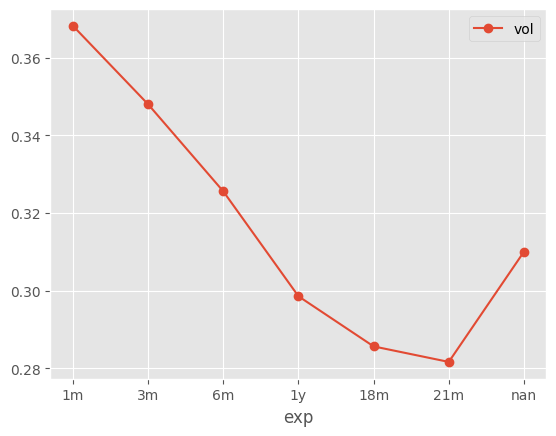

In [ ]:
from pandas import Categorical
exp_vols = vols[vols.index.get_level_values('strike')==1.0]
exp_vols.reset_index(inplace=True)

exp_vols['exp'] = Categorical(exp_vols['exp'], categories=['1m', '3m', '6m', '1y', '18m', '21m'], ordered=True)
exp_vols.sort_values(by='exp', inplace=True)
exp_vols.plot(x='exp', y='vol', kind='line', marker='o')

## Heat Map Aggregate

In [ ]:
from copy import deepcopy
# BASE_PRICING_CONFIG = deepcopy(PRICING_CONFIG)
chain_editable=deepcopy(chains)
from itertools import product
width_range = np.arange(0.5, 1, 0.1)
dte_range= np.arange(0, 70, 10)
combos=list(product(width_range, dte_range))

In [ ]:
all_combos = []
for combo_choice in combos:
    meta={}
    _k_grid_editable = {}
    _t_grid_editable = {}
    _market_iv_grid_editable = {}
    _fwd_grid_editable = {}
    _atm_iv_editable = {}
    _atm_T_editable = {}
    # print(f"Testing combo: {combo_choice}")

    PRICING_CONFIG['VOL_SURFACE_WIDTH'] = combo_choice[0]
    PRICING_CONFIG['VOL_SURFACE_MIN_DTE_THRESHOLD'] = combo_choice[1]
    meta['VOL_SURFACE_WIDTH'] = combo_choice[0]
    meta['VOL_SURFACE_MIN_DTE_THRESHOLD'] = combo_choice[1]
    meta['TICK_PARAMS'] = {}
    for tick in chain_editable:
        # if tick != 'AAPL' or combo_choice[1] != 0:
        #     continue
        print(f"Processing {tick} with combo {combo_choice}")
        chain_editable[tick] = confine_chain_with_pricing_config(chains[tick])
        print(f"Shape of chain_editable[{tick}]: {chain_editable[tick].shape}")
        chain_editable[tick]['vol'] = chain_editable[tick]['crr_vol_discrete']
        (var0_hat, var_inf_hat, kappa_hat), atm_loss = get_best_params(
            get_atm_T_maturities_on_chain(chain_editable[tick]),
            get_atm_T_vols_on_chain(chain_editable[tick])
        )
        params[tick] = {
            'var0_hat': var0_hat,
            'var_inf_hat': var_inf_hat,
            'kappa_hat': kappa_hat,
            'atm_loss': atm_loss
        }
        _k_grid_editable[tick] = get_K_grid(chain_editable[tick])
        _t_grid_editable[tick] = get_T_grid(chain_editable[tick])
        _market_iv_grid_editable[tick] = get_market_iv_grid(chain_editable[tick])
        _fwd_grid_editable[tick] = get_fwd_grid(chain_editable[tick])

        eta_hat, lambda_hat, rho_hat, best_loss = get_surface_params(
            get_K_grid(chain_editable[tick]),
            get_T_grid(chain_editable[tick]),
            get_fwd_grid(chain_editable[tick]),
            params[tick]['var0_hat'],
            params[tick]['var_inf_hat'],
            params[tick]['kappa_hat'],
            get_market_iv_grid(chain_editable[tick])
        )
        params[tick].update({
            'eta_hat': eta_hat,
            'lambda_hat': lambda_hat,
            'rho_hat': rho_hat,
            'surface_loss': best_loss
        })
        meta['TICK_PARAMS'][tick] = params[tick]
        print(f"Done for {tick} with combo {combo_choice}")
        print(f"Surface Loss for {tick}: {params[tick]['surface_loss']}")
    print(f"Done processing combo: {combo_choice}")
    all_combos.append({
        'meta': meta,
        'k_grid': _k_grid_editable,
        't_grid': _t_grid_editable,
        'market_iv_grid': _market_iv_grid_editable,
        'fwd_grid': _fwd_grid_editable
    })
    

Processing AAPL with combo (0.5, 0)
Shape of chain_editable[AAPL]: (1418, 22)
Done for AAPL with combo (0.5, 0)
Surface Loss for AAPL: 0.03263895401751859
Processing MSFT with combo (0.5, 0)
Shape of chain_editable[MSFT]: (2490, 22)
Done for MSFT with combo (0.5, 0)
Surface Loss for MSFT: 0.03174952801335476
Processing GOOGL with combo (0.5, 0)
Shape of chain_editable[GOOGL]: (1232, 22)
Done for GOOGL with combo (0.5, 0)
Surface Loss for GOOGL: 0.02549826077238575
Processing AMZN with combo (0.5, 0)
Shape of chain_editable[AMZN]: (1468, 22)
Done for AMZN with combo (0.5, 0)
Surface Loss for AMZN: 0.023943976939988225
Processing TSLA with combo (0.5, 0)
Shape of chain_editable[TSLA]: (2098, 22)
Done for TSLA with combo (0.5, 0)
Surface Loss for TSLA: 0.017454629714797484
Done processing combo: (0.5, 0)
Processing AAPL with combo (0.5, 10)
Shape of chain_editable[AAPL]: (1204, 22)
Done for AAPL with combo (0.5, 10)
Surface Loss for AAPL: 0.006238815762247019
Processing MSFT with combo (0

In [ ]:
surface_meta_mean = []
for m in all_combos:
    data={}
    data['VOL_SURFACE_WIDTH'] = m['meta']['VOL_SURFACE_WIDTH']
    data['VOL_SURFACE_MIN_DTE_THRESHOLD'] = m['meta']['VOL_SURFACE_MIN_DTE_THRESHOLD']
    data['mean_surface_loss'] = np.mean(
        [v['surface_loss'] for v in m['meta']['TICK_PARAMS'].values()]
    )
    surface_meta_mean.append(data)    

error_df = pd.DataFrame(surface_meta_mean)
error_df

,VOL_SURFACE_WIDTH,VOL_SURFACE_MIN_DTE_THRESHOLD,mean_surface_loss
0,0.5,0,0.026257
1,0.5,10,0.005381
2,0.5,20,0.004007
3,0.5,30,0.003170
4,0.5,40,0.002146
5,0.5,50,0.001695
6,0.5,60,0.001695
7,0.6,0,0.037022
8,0.6,10,0.006848
9,0.6,20,0.005369


In [ ]:
error_df.pivot_table(
    index="VOL_SURFACE_WIDTH", 
    columns="VOL_SURFACE_MIN_DTE_THRESHOLD", 
    values="mean_surface_loss", 
    aggfunc='sum'
)

VOL_SURFACE_MIN_DTE_THRESHOLD,0,10,20,30,40,50,60
VOL_SURFACE_WIDTH,,,,,,,
0.5,0.026257,0.005381,0.004007,0.003170,0.002146,0.001695,0.001695
0.6,0.037022,0.006848,0.005369,0.004506,0.002802,0.002288,0.002288
0.7,0.042242,0.007557,0.006201,0.005403,0.003571,0.003135,0.003135
0.8,0.043829,0.008377,0.006979,0.006166,0.004459,0.004000,0.004000
0.9,0.046104,0.010033,0.008603,0.007830,0.006261,0.005683,0.005683


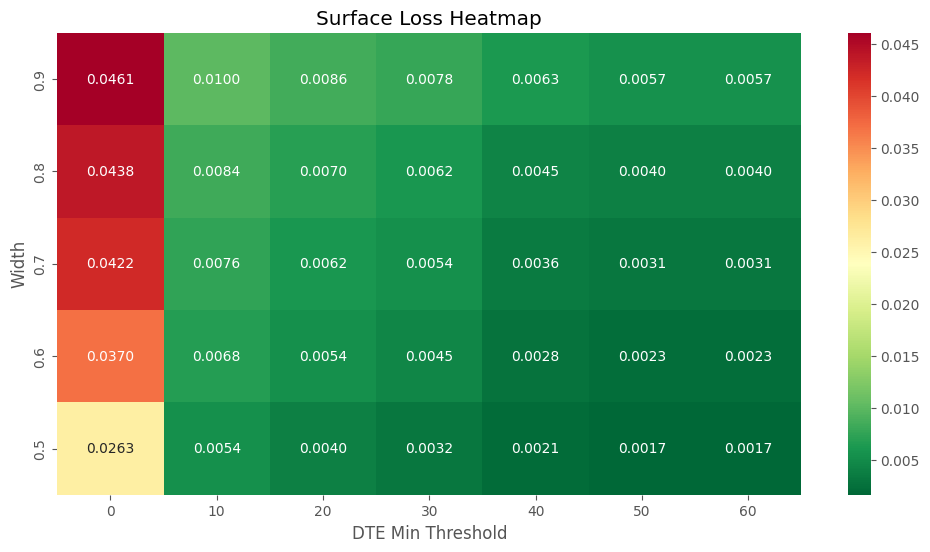

In [ ]:

## Plot Heat Map
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
# heatmap_data = error_df.pivot(index="width", columns="DTE_MIN_THRESHOLD",values="surface_loss")
heatmap_data = error_df.pivot_table(
    index="VOL_SURFACE_WIDTH", 
    columns="VOL_SURFACE_MIN_DTE_THRESHOLD", 
    values="mean_surface_loss", 
    aggfunc='mean'
)
heatmap_data.index = heatmap_data.index.round(2)
heatmap_data=heatmap_data.iloc[::-1]
sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap="RdYlGn_r")
plt.title("Surface Loss Heatmap")
plt.xlabel("DTE Min Threshold")
plt.ylabel("Width")
plt.show()

In [ ]:
european_converted_chain

,root,expiration,strike,right,bid_size,closebid,ask_size,closeask,date,midpoint,...,bs_vol,intrinsic_value,eu_lower_bound,lower_bound,upper_bound,european_midpoint,american_midpoint,early_exercise_premium,european_equivalent_mid,european_vols_equiv
0,TSLA,2025-08-22,215.0,P,10,0.82,95,0.86,20250716,0.840,...,0.710251,0.000000,0.000000,0.000000,215.0,0.840168,0.834866,0.000000,0.840000,0.710251
1,TSLA,2025-08-22,215.0,C,21,107.85,18,109.50,20250716,108.675,...,0.744995,106.670013,107.589753,107.589753,215.0,108.675066,108.675043,0.000000,108.675000,0.744995
2,TSLA,2025-08-29,215.0,P,3,1.02,6,1.05,20250716,1.035,...,0.678131,0.000000,0.000000,0.000000,215.0,1.034915,1.037159,0.002244,1.032756,0.677882
3,TSLA,2025-08-29,215.0,C,26,108.00,31,110.35,20250716,109.175,...,0.720999,106.670013,107.763315,107.763315,215.0,109.174893,109.173417,0.000000,109.175000,0.720999
4,TSLA,2026-07-17,210.0,P,2,16.30,4,16.50,20250716,16.400,...,0.570025,0.000000,0.000000,0.000000,210.0,16.396771,16.633026,0.236254,16.163746,0.566651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4737,TSLA,2025-07-18,215.0,P,60,0.01,145,0.02,20250716,0.015,...,1.832929,0.000000,0.000000,0.000000,215.0,0.015004,0.014670,0.000000,0.015000,1.832929
4738,TSLA,2025-08-01,215.0,C,1,106.80,18,108.35,20250716,107.575,...,0.985578,106.670013,107.068223,107.068223,215.0,107.575160,107.574173,0.000000,107.575000,0.985578
4739,TSLA,2025-08-01,215.0,P,120,0.33,28,0.35,20250716,0.340,...,0.926463,0.000000,0.000000,0.000000,215.0,0.340004,0.339081,0.000000,0.340000,0.926463
4740,TSLA,2025-08-15,215.0,C,6,108.00,7,108.55,20250716,108.275,...,0.790612,106.670013,107.416051,107.416051,215.0,108.275126,108.267384,0.000000,108.275000,0.790612


In [ ]:
import numpy as np
import pandas as pd

# -------------------- American → European (de-Americanize) --------------------

def _eep_baw_or_bs2002(option_type: str, S: float, K: float, T: float,
                       r: float, q: float, sigma: float,
                       discrete_divs: list[tuple[float, float]] | None = None) -> float:
    """
    Estimate Early Exercise Premium (EEP) for an American vanilla option.
    Returns EEP >= 0 to subtract from the American price to get European price.
    TODO: Plug in your existing BAW or Bjerksund-Stensland implementation here.
    """
    # e.g., price_A = bjerksund_stensland_2002(...)
    #       price_E = black_scholes(...)
    #       return max(price_A - price_E, 0.0)
    raise NotImplementedError("Wire your BAW/BS2002 here")

def _invert_black_for_iv(option_type: str, S: float, K: float, T: float,
                         r: float, q: float, price_euro: float,
                         iv_init: float | None = None, tol: float = 1e-7, max_iter: int = 50) -> float:
    """
    Solve for Black-Scholes European IV given a target European price.
    Use your existing robust IV solver; this is just an interface shim.
    """
    # TODO: call your existing implied vol solver
    raise NotImplementedError("Connect to your IV solver here")

def de_americanize_quotes(df: pd.DataFrame,
                          r: float, q: float,
                          discrete_divs: list[tuple[float, float]] | None = None,
                          eep_iters: int = 2) -> pd.DataFrame:
    """
    Convert American mid prices to European-equivalent IVs by iterating:
    1) start with df['mid_iv'] (or a seed) as sigma
    2) estimate EEP with BAW/BS2002
    3) price_E = price_A - EEP
    4) invert for sigma_E (European IV)
    A couple iterations are usually plenty.
    Expects columns: ['right','S','strike','t','mid_price','mid_iv']
    Returns: new column 'euro_iv'
    """
    out = df.copy()
    # seed: use current iv if present
    if 'mid_iv' in out:
        out['euro_iv'] = pd.to_numeric(out['mid_iv'], errors='coerce')
    else:
        out['euro_iv'] = np.nan

    for _ in range(eep_iters):
        next_iv = []
        for _, row in out.iterrows():
            right = str(row['right']).upper()[0]
            S  = float(row['S']);    K = float(row['strike'])
            T  = float(row['t']);    Pm = float(row['mid_price'])
            iv = float(row['euro_iv']) if np.isfinite(row['euro_iv']) else 0.20  # fallback seed

            # EEP estimate (depends on IV)
            eep = _eep_baw_or_bs2002(right, S, K, T, r, q, iv, discrete_divs)
            price_euro = max(Pm - eep, 0.0)

            # invert to new IV_E
            iv_e = _invert_black_for_iv(right, S, K, T, r, q, price_euro, iv_init=iv)
            next_iv.append(iv_e)
        out['euro_iv'] = next_iv
    return out

# -------------------- D(T) via box spreads; F(T) via parity -------------------

def _compute_discount_from_box(expiry_df: pd.DataFrame) -> float:
    """
    Estimate D(T) using box spreads:
    D ≈ ((C(K1)-C(K2)) - (P(K1)-P(K2))) / (K2 - K1), averaged over pairs.
    Expects: euro call/put prices in columns ['call_euro_price','put_euro_price'] at same expiry.
    """
    df = expiry_df.dropna(subset=['strike','call_euro_price','put_euro_price']).sort_values('strike')
    Ks = df['strike'].to_numpy()
    C  = df['call_euro_price'].to_numpy()
    P  = df['put_euro_price'].to_numpy()

    Ds = []
    for i in range(len(Ks) - 1):
        K1, K2 = Ks[i], Ks[i+1]
        C1, C2 = C[i], C[i+1]
        P1, P2 = P[i], P[i+1]
        denom = (K2 - K1)
        if denom > 0:
            Ds.append(((C1 - C2) - (P1 - P2)) / denom)
    Ds = np.array([d for d in Ds if np.isfinite(d) and d > 0])
    if len(Ds) == 0:
        raise ValueError("Could not infer discount factor from box spreads at this expiry.")
    # robust location
    return float(np.median(np.clip(Ds, 1e-6, 1.0)))

def _vega_spread_weights(df: pd.DataFrame) -> np.ndarray:
    """
    w = vega / (1 + rel_spread), clipped to avoid extremes.
    Expects 'vega' and optional 'rel_spread'.
    """
    vega = pd.to_numeric(df['vega'], errors='coerce').fillna(0.0).to_numpy()
    rs   = pd.to_numeric(df.get('rel_spread', np.nan), errors='coerce').to_numpy()
    rs   = np.where(np.isfinite(rs) & (rs > 0), rs, 0.0)
    w    = vega / (1.0 + rs)
    return np.where(np.isfinite(w), np.clip(w, 0.0, np.nanpercentile(w, 95)), 0.0)

def infer_forward_from_parity(expiry_df: pd.DataFrame, D: float) -> float:
    """
    With Europeanized prices and discount D(T), get per-strike F_i = K + (C - P)/D,
    then return a robust, weighted estimator F*.
    Expects: columns ['strike','call_euro_price','put_euro_price','vega','rel_spread'].
    """
    K = pd.to_numeric(expiry_df['strike'], errors='coerce').to_numpy()
    C = pd.to_numeric(expiry_df['call_euro_price'], errors='coerce').to_numpy()
    P = pd.to_numeric(expiry_df['put_euro_price'], errors='coerce').to_numpy()
    Fi = K + (C - P) / max(D, 1e-8)

    w  = _vega_spread_weights(expiry_df)
    mask = np.isfinite(Fi) & (w > 0)
    if mask.sum() < 3:
        return float(np.nanmedian(Fi))

    # trimmed, weighted median
    Fi, w = Fi[mask], w[mask] ## Keep finite values
    lo, hi = np.nanpercentile(Fi, [10, 90]) ## Filter out extremes
    keep   = (Fi >= lo) & (Fi <= hi) ## Extreme filtered mask
    Fi, w  = Fi[keep], w[keep] ## Apply mask
    # weighted median
    order = np.argsort(Fi) ## Produce sorted indices for Implied Forward.
    Fi, w = Fi[order], w[order] ## Reorder by Implied Forward
    csum = np.cumsum(w) / np.sum(w) ## Cumsum to get cumulative weights
    j = np.searchsorted(csum, 0.5) ## Pick the index where cumulative weight crosses 0.5
    return float(Fi[min(j, len(Fi)-1)])

def recompute_log_moneyness(df: pd.DataFrame, F_star: float) -> pd.DataFrame:
    out = df.copy()
    out['log_moneyness'] = np.log(pd.to_numeric(out['strike'], errors='coerce') / float(F_star))
    return out


In [ ]:
# np.nanpercentile(np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]), [10, 90])
np.argsort(np.array([1, 2, 3, 4, 5, 6, 7, 8, 11, 10])) # [0 1 2 3 4 5 6 7 8 9]
np.searchsorted?

Signature: np.searchsorted(a, v, side='left', sorter=None)
Docstring:
Find indices where elements should be inserted to maintain order.

Find the indices into a sorted array `a` such that, if the
corresponding elements in `v` were inserted before the indices, the
order of `a` would be preserved.

Assuming that `a` is sorted:

======  ============================
`side`  returned index `i` satisfies
======  ============================
left    ``a[i-1] < v <= a[i]``
right   ``a[i-1] <= v < a[i]``
======  ============================

Parameters
----------
a : 1-D array_like
    Input array. If `sorter` is None, then it must be sorted in
    ascending order, otherwise `sorter` must be an array of indices
    that sort it.
v : array_like
    Values to insert into `a`.
side : {'left', 'right'}, optional
    If 'left', the index of the first suitable location found is given.
    If 'right', return the last such index.  If there is no suitable
    index, return either 0 or N (where N is the 

In [ ]:
r = get_rates(european_converted_chain['valuation_date'].iloc[0])
european_converted_chain.columns

Index(['root', 'expiration', 'strike', 'right', 'bid_size', 'closebid',
       'ask_size', 'closeask', 'date', 'midpoint', 'weighted_midpoint', 'spot',
       'valuation_date', 'moneyness', 'log_moneyness', 't', 'dte', 'f',
       'f_moneyness', 'f_log_moneyness', 'div_schedule', 'bs_vol',
       'intrinsic_value', 'eu_lower_bound', 'lower_bound', 'upper_bound',
       'european_midpoint', 'american_midpoint', 'early_exercise_premium',
       'european_equivalent_mid', 'european_vols_equiv', 'vega'],
      dtype='object')

In [ ]:
chain_for_box.expiration.unique()

<DatetimeArray>
['2025-07-18 00:00:00', '2025-07-25 00:00:00', '2025-08-01 00:00:00',
 '2025-08-08 00:00:00', '2025-08-15 00:00:00', '2025-08-22 00:00:00',
 '2025-08-29 00:00:00', '2025-09-19 00:00:00', '2025-10-17 00:00:00',
 '2025-11-21 00:00:00', '2025-12-19 00:00:00', '2026-01-16 00:00:00',
 '2026-02-20 00:00:00', '2026-03-20 00:00:00', '2026-05-15 00:00:00',
 '2026-06-18 00:00:00', '2026-07-17 00:00:00', '2026-09-18 00:00:00',
 '2026-12-18 00:00:00', '2027-01-15 00:00:00', '2027-06-17 00:00:00',
 '2027-12-17 00:00:00']
Length: 22, dtype: datetime64[ns]

In [ ]:
vectorized_black_scholes_greeks?

Signature:
vectorized_black_scholes_greeks(
    F: List[str],
    S: List[float],
    K: List[float],
    valuation_dates: List[datetime.datetime],
    end_dates: List[datetime.datetime],
    r: List[float],
    sigma: List[float],
    option_type: Union[str, List[str]] = 'c',
    div_type='discrete',
    div_amount=None,
) -> dict
Docstring:
Vectorized Black-Scholes Greeks calculation.
F: Forward prices (array)
S: Spot prices (array)
K: Strike prices (array)
valuation_dates: List of valuation dates (dates for which the option is priced)
end_dates: List of end dates (expiration dates of the options)
r: Risk-free rates (annualized, array)
sigma: Volatilities (annualized, array)
option_type: "c" for call, "p" for put (single string or list of strings)
div_type: Type of dividend ('discrete' or 'continuous')
div_amount: Dividend amount (single float or list of floats, ignored for continuous dividends)
Returns: Greeks (dictionary)
File:      ~/cloned_repos/QuantTools/module_test/raw_code/op

In [ ]:
div_pv = vectorized_discrete_pv(
    european_converted_chain['div_schedule'].values,
    r = [get_rates(european_converted_chain['valuation_date'].iloc[0].strftime('%Y-%m-%d'))] * len(european_converted_chain),
    _valuation_dates= european_converted_chain['valuation_date'].values,
    _end_dates= european_converted_chain['expiration'].values
)
greeks = vectorized_black_scholes_greeks(
    F=european_converted_chain['f'].values,
    S= european_converted_chain['spot'].values,
    K= european_converted_chain['strike'].values,
    valuation_dates= european_converted_chain['valuation_date'].values,
    end_dates= european_converted_chain['expiration'].values,
    r= [get_rates(european_converted_chain['valuation_date'].iloc[0].strftime('%Y-%m-%d'))] * len(european_converted_chain),
    sigma = european_converted_chain['european_vols_equiv'].values,
    option_type= european_converted_chain['right'].str.lower().values,
    div_type='discrete',
    div_amount= div_pv
)

In [ ]:
european_converted_chain['vega'] = greeks['vega']
# european_converted_chain['rel_c'] = greeks['']

<Axes: xlabel='expiration'>

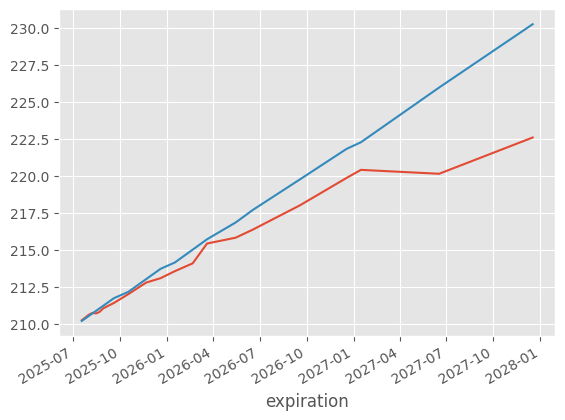

In [ ]:
# _compute_discount_from_box(european_converted_chain,
#                            )

chain_for_box = european_converted_chain.pivot_table(
    index = ['expiration', 'strike', 'valuation_date',],
    columns = 'right',
    values = ['midpoint', 'closebid', 'closeask', 'vega']
).reset_index()
chain_for_box.columns = chain_for_box.columns.map(lambda x: f"{x[0]}_{x[1]}" if x[1] != '' else x[0])
chain_for_box['call_euro_price'] = chain_for_box['midpoint_C']
chain_for_box['put_euro_price'] = chain_for_box['midpoint_P']
chain_for_box.drop(columns=['midpoint_C', 'midpoint_P'], inplace=True)
chain_for_box['rel_spread_c'] = (
    chain_for_box['closeask_C'] - chain_for_box['closebid_C']
) / chain_for_box['call_euro_price']

chain_for_box['rel_spread_p'] = (
    chain_for_box['closeask_P'] - chain_for_box['closebid_P']
) / chain_for_box['put_euro_price']

chain_for_box['vega'] = chain_for_box.apply(lambda x: min(x['vega_C'], x['vega_P']), axis=1)
chain_for_box['rel_spread'] = chain_for_box.apply(
    lambda x: min(x['rel_spread_c'], x['rel_spread_p']), axis=1
)


# chain_for_box.expiration.unique()

D_by_exp = chain_for_box.groupby('expiration').apply(
    lambda df: _compute_discount_from_box(df)
)

F_by_exp = chain_for_box.groupby('expiration').apply(
    lambda df: infer_forward_from_parity(df, D=D_by_exp[df['expiration'].iloc[0]])
)

T_by_exp = chain_for_box.groupby('expiration').apply(
    lambda df: time_distance_helper(
        df['expiration'].iloc[0], df['valuation_date'].iloc[0]
    )
)

implied_discount_premium = r +( np.log(D_by_exp) / T_by_exp)

mkt_f_by_exp = european_converted_chain.groupby('expiration').f.last()
implied_discount_premium
F_by_exp.plot()
mkt_f_by_exp.plot()


<Axes: xlabel='expiration'>

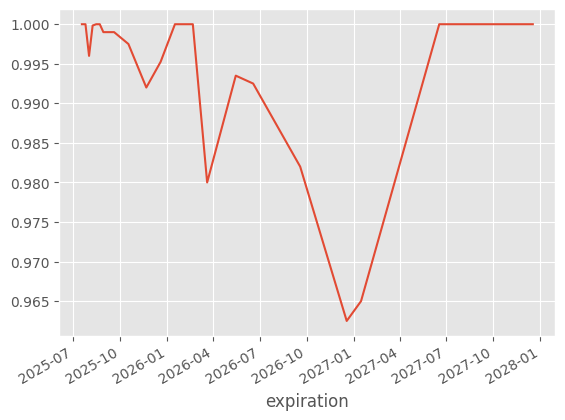

In [ ]:
D_by_exp.plot()

In [ ]:
get_bs_vol_on_chain?

Signature:
get_bs_vol_on_chain(
    chain: pandas.core.frame.DataFrame,
    valuation_date: str,
) -> pandas.core.series.Series
Docstring:
Estimates the Black-Scholes implied volatility for a given option chain.

Args:
    chain (pd.DataFrame): The option chain DataFrame.
        Expected Columns: `f`, `strike`, `t`, `midpoint`, `right`. 
    valuation_date (str): The date of valuation.
    
Returns:
    pd.Series: The estimated Black-Scholes implied volatility for the option chain.
File:      /var/folders/j0/80hkbygd4lb27h9mw76gqzpw0000gn/T/ipykernel_37786/2020857283.py
Type:      function

In [ ]:
tester=chain_for_box.set_index(['expiration'])
tester['f'] = F_by_exp
tester['t'] = T_by_exp
tester = tester.reset_index().melt(
    id_vars = ['expiration', 'strike', 'valuation_date', 'f', 't'],
    value_vars = ['call_euro_price', 'put_euro_price'],
    value_name = 'midpoint'
).dropna().reset_index(drop=True)   
tester['right'] = tester['variable'].str.split('_').str[0].str[0].str.upper()
tester['equalized_iv']=get_bs_vol_on_chain(
    tester,
    valuation_date=tester['valuation_date'].iloc[0],
)
tester

,expiration,strike,valuation_date,f,t,variable,midpoint,right,equalized_iv
0,2025-07-18,110.0,2025-07-16 16:00:00,210.260555,0.005476,call_euro_price,100.375000,C,3.747594
1,2025-07-18,115.0,2025-07-16 16:00:00,210.260555,0.005476,call_euro_price,95.475000,C,3.776839
2,2025-07-18,120.0,2025-07-16 16:00:00,210.260555,0.005476,call_euro_price,90.475000,C,3.533382
3,2025-07-18,130.0,2025-07-16 16:00:00,210.260555,0.005476,call_euro_price,80.475000,C,3.074212
4,2025-07-18,135.0,2025-07-16 16:00:00,210.260555,0.005476,call_euro_price,75.400000,C,2.702652
...,...,...,...,...,...,...,...,...,...
2019,2027-12-17,420.0,2025-07-16 16:00:00,226.341874,2.420260,put_euro_price,194.528686,P,0.452546
2020,2027-12-17,425.0,2025-07-16 16:00:00,226.341874,2.420260,put_euro_price,199.261261,P,0.458920
2021,2027-12-17,430.0,2025-07-16 16:00:00,226.341874,2.420260,put_euro_price,203.994795,P,0.465294
2022,2027-12-17,435.0,2025-07-16 16:00:00,226.341874,2.420260,put_euro_price,208.727394,P,0.471543


In [ ]:
tester.expiration.unique()

<DatetimeArray>
['2025-07-18 00:00:00', '2025-07-25 00:00:00', '2025-08-01 00:00:00',
 '2025-08-08 00:00:00', '2025-08-15 00:00:00', '2025-08-22 00:00:00',
 '2025-08-29 00:00:00', '2025-09-19 00:00:00', '2025-10-17 00:00:00',
 '2025-11-21 00:00:00', '2025-12-19 00:00:00', '2026-01-16 00:00:00',
 '2026-02-20 00:00:00', '2026-03-20 00:00:00', '2026-05-15 00:00:00',
 '2026-06-18 00:00:00', '2026-09-18 00:00:00', '2026-12-18 00:00:00',
 '2027-01-15 00:00:00', '2027-06-17 00:00:00', '2027-12-17 00:00:00']
Length: 21, dtype: datetime64[ns]

In [ ]:
tester.dropna()

,expiration,strike,valuation_date,f,t,variable,midpoint,right,equalized_iv
0,2025-07-18,110.0,2025-07-16 16:00:00,210.260555,0.005476,call_euro_price,100.375000,C,3.747594
1,2025-07-18,115.0,2025-07-16 16:00:00,210.260555,0.005476,call_euro_price,95.475000,C,3.776839
2,2025-07-18,120.0,2025-07-16 16:00:00,210.260555,0.005476,call_euro_price,90.475000,C,3.533382
3,2025-07-18,130.0,2025-07-16 16:00:00,210.260555,0.005476,call_euro_price,80.475000,C,3.074212
4,2025-07-18,135.0,2025-07-16 16:00:00,210.260555,0.005476,call_euro_price,75.400000,C,2.702652
...,...,...,...,...,...,...,...,...,...
2019,2027-12-17,420.0,2025-07-16 16:00:00,226.341874,2.420260,put_euro_price,194.528686,P,0.452546
2020,2027-12-17,425.0,2025-07-16 16:00:00,226.341874,2.420260,put_euro_price,199.261261,P,0.458920
2021,2027-12-17,430.0,2025-07-16 16:00:00,226.341874,2.420260,put_euro_price,203.994795,P,0.465294
2022,2027-12-17,435.0,2025-07-16 16:00:00,226.341874,2.420260,put_euro_price,208.727394,P,0.471543


<Axes: title={'center': 'Implied Volatility Surface for 2027-12-17 Expiration'}, xlabel='Strike Price', ylabel='Implied Volatility'>

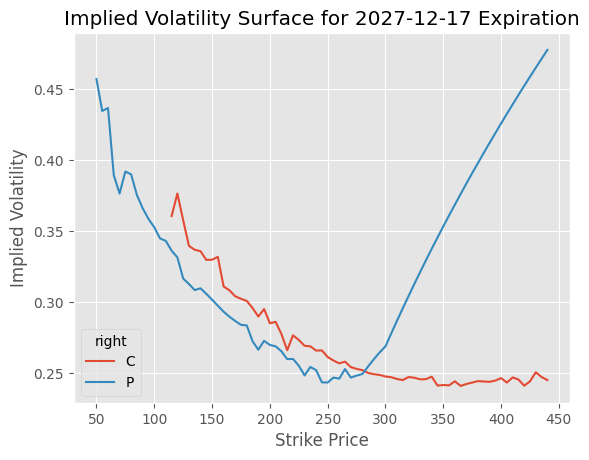

In [ ]:
tester[tester.expiration == exp].pivot_table(
    columns='right',
    index='strike',
    values='equalized_iv'
).plot(
    kind='line',
    title='Implied Volatility Surface for 2027-12-17 Expiration',
    ylabel='Implied Volatility',
    xlabel='Strike Price'
)